<a href="https://colab.research.google.com/github/KarolSzozda/Project_0/blob/main/Final_Pollution_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Połączenie z dyskiem**

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Wstęp**
Zjawisko smogu w ostatnich latach zdecydowanie przybrało na znaczeniu, stało się bardziej powszechne oraz zyskało na medialności. W Polsce niechlubne miano synonimu smogu przyznano miastu Kraków. Chociaż dla osób zamieszkujących to miejsce, z biegiem lat zjawisko te spowszechniało, tak dla ludzi odwiedzających miasto jest ono nie rzadko wręcz przytłaczające. Wjeżdżając do Krakowa, można na własnej skórze doświadczyć, jak początkowo niebieskie niebo szarzeje, żeby na końcu stać się znacząco przydymionym. W stolicy małopolski na stan ten znaczący wpływ mają takie czynniki niekorzystne położenia miasta w dolinie Wisły, słaba jakość infrastruktury grzewczej (stare piece grzewcze, niskiej jakości opał), jak i zanieczyszczenia przemysłowe oraz komunikacyjne. Poza oczywistymi efektami wizualnymi smog niestety niesie ze sobą wiele innych, bardziej niebezpiecznych konsekwencji dla zdrowia człowieka.

---

W styczniu 2017 w południowej Polsce wystąpiło rekordowo wysokie zanieczyszczenie powietrza. Z uwagi na dostepność danych z tego roku, postanowiliśmy stworzyć model prognozujacy szacunkowe stężenie pyłów PM10 bazując na danych pochodzących z 56 czujników rozlokowanych w różnych częściach Krakowa. Pod uwagę wzięlismy korelację steżenia pyłów w stosunku do warunków atmosferycznych takich jak: temperatura powietrza, wilgotność, ciśnienie czy prędkość wiatru.

---
Dodatkowe informacje:


*   PM1 nie jest skalibrowany i dlatego może być większy niż PM2,5
*   PM2,5 może być większy niż PM10 w granicach błędu pomiaru
*   Przez pierwsze dwa miesiące wilgotność i temperatura nie były kalibrowane i dlatego mogą pokazywać niedokładne wartości


# **Importy**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import time
from numpy.ma.core import equal
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

# **Wczytywanie danych**

In [3]:
jan = pd.read_csv('/content/january-2017.csv')
feb = pd.read_csv('/content/february-2017.csv')
mar = pd.read_csv('/content/march-2017.csv')
apr = pd.read_csv('/content/april-2017.csv')
may = pd.read_csv('/content/may-2017.csv')
jun = pd.read_csv('/content/june-2017.csv')
jul = pd.read_csv('/content/july-2017.csv')
aug = pd.read_csv('/content/august-2017.csv')
sep = pd.read_csv('/content/september-2017.csv')
oct = pd.read_csv('/content/october-2017.csv')
nov = pd.read_csv('/content/november-2017.csv')
dec = pd.read_csv('/content/december-2017.csv')
sensors = pd.read_csv('/content/sensor_locations.csv')
wind = pd.read_csv('/content/Wiatr.csv')

In [4]:
year_2017 = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec]) #Łączenie table z miesiącami w jedną tabelę
year_2017

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01T01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01T02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01T03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01T04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,2017-12-24T20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,87.0,101736.0,...,101726.0,12.0,15.0,31.0,5.0,85.0,101798.0,13.0,15.0,26.0
573,2017-12-24T21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,88.0,101776.0,...,101771.0,12.0,14.0,29.0,5.0,85.0,101840.0,12.0,13.0,23.0
574,2017-12-24T22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,85.0,101785.0,...,101788.0,10.0,12.0,26.0,5.0,82.0,101839.0,10.0,12.0,21.0
575,2017-12-24T23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.0,88.0,101782.0,...,101774.0,9.0,11.0,24.0,5.0,85.0,101837.0,10.0,12.0,21.0


# **Analiza danych**

In [5]:
for c in year_2017.columns: #Prinotwanie nazw kolumn w tabeli
  print(c)

UTC time
3_temperature
3_humidity
3_pressure
3_pm1
3_pm25
3_pm10
140_temperature
140_humidity
140_pressure
140_pm1
140_pm25
140_pm10
142_temperature
142_humidity
142_pressure
142_pm1
142_pm25
142_pm10
147_temperature
147_humidity
147_pressure
147_pm1
147_pm25
147_pm10
169_temperature
169_humidity
169_pressure
169_pm1
169_pm25
169_pm10
170_temperature
170_humidity
170_pressure
170_pm1
170_pm25
170_pm10
171_temperature
171_humidity
171_pressure
171_pm1
171_pm25
171_pm10
172_temperature
172_humidity
172_pressure
172_pm1
172_pm25
172_pm10
173_temperature
173_humidity
173_pressure
173_pm1
173_pm25
173_pm10
174_temperature
174_humidity
174_pressure
174_pm1
174_pm25
174_pm10
176_temperature
176_humidity
176_pressure
176_pm1
176_pm25
176_pm10
177_temperature
177_humidity
177_pressure
177_pm1
177_pm25
177_pm10
178_temperature
178_humidity
178_pressure
178_pm1
178_pm25
178_pm10
179_temperature
179_humidity
179_pressure
179_pm1
179_pm25
179_pm10
180_temperature
180_humidity
180_pressure
180_pm1
1

In [6]:
year_2017.dtypes

UTC time          object
3_temperature    float64
3_humidity       float64
3_pressure       float64
3_pm1            float64
                  ...   
895_humidity     float64
895_pressure     float64
895_pm1          float64
895_pm25         float64
895_pm10         float64
Length: 337, dtype: object

In [7]:
year_2017['UTC time'] = pd.to_datetime(year_2017['UTC time']) #Zmiana typu danych w kolumnie 'UTC time' na datetime
year_2017.dtypes

UTC time         datetime64[ns]
3_temperature           float64
3_humidity              float64
3_pressure              float64
3_pm1                   float64
                      ...      
895_humidity            float64
895_pressure            float64
895_pm1                 float64
895_pm25                float64
895_pm10                float64
Length: 337, dtype: object

In [8]:
#Funkcja sprawdzająca liczbe wartości i wystąpień NaN w poszczególnych kolumnach
all_sensors_id = []
all_types = []

for c in year_2017.columns:   
  print(c, pd.isna(year_2017[c]).sum(), len(year_2017[c]))
  try:
    if c == 'UTC time': 
      continue
    res = c.split('_')
    all_sensors_id.append(res[0]) 
    all_types.append(res[1])
  except:
    print('Error in column', c, 'continue')
    continue

UTC time 0 8593
3_temperature 8387 8593
3_humidity 8387 8593
3_pressure 7415 8593
3_pm1 7358 8593
3_pm25 7358 8593
3_pm10 7358 8593
140_temperature 2087 8593
140_humidity 2087 8593
140_pressure 1910 8593
140_pm1 1962 8593
140_pm25 1962 8593
140_pm10 1962 8593
142_temperature 6527 8593
142_humidity 6528 8593
142_pressure 6552 8593
142_pm1 6603 8593
142_pm25 6603 8593
142_pm10 6603 8593
147_temperature 6292 8593
147_humidity 6294 8593
147_pressure 653 8593
147_pm1 628 8593
147_pm25 628 8593
147_pm10 628 8593
169_temperature 331 8593
169_humidity 333 8593
169_pressure 356 8593
169_pm1 332 8593
169_pm25 331 8593
169_pm10 331 8593
170_temperature 133 8593
170_humidity 134 8593
170_pressure 158 8593
170_pm1 133 8593
170_pm25 133 8593
170_pm10 133 8593
171_temperature 79 8593
171_humidity 81 8593
171_pressure 104 8593
171_pm1 79 8593
171_pm25 79 8593
171_pm10 79 8593
172_temperature 6997 8593
172_humidity 6997 8593
172_pressure 230 8593
172_pm1 205 8593
172_pm25 205 8593
172_pm10 205 8593
173

In [9]:
#Funkcja printująca procentowy udział wartości NaN do wszystkich wartości w kolumnie
def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total / len(df) * 100
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print(concat)

In [10]:
printNullValues(year_2017)

                 Total     Percent
203_pressure      8593  100.000000
178_pressure      8593  100.000000
3_humidity        8387   97.602700
3_temperature     8387   97.602700
183_pressure      7639   88.897940
...                ...         ...
212_humidity         9    0.104736
212_pm10             8    0.093099
212_pm25             8    0.093099
212_pm1              8    0.093099
212_temperature      8    0.093099

[336 rows x 2 columns]


In [11]:
year_2017.describe() #Podstawowe metryki dla poszczególnych kolumn

,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
count,206.000000,206.000000,1178.000000,1235.000000,1235.000000,1235.000000,6506.000000,6506.000000,6683.000000,6631.000000,...,2653.000000,2653.000000,2653.000000,2653.000000,5443.000000,5443.000000,6337.000000,6337.000000,6337.000000,6337.000000
mean,-5.131068,74.718447,101652.880306,70.830769,75.454251,112.540891,11.464494,80.271288,101639.084842,26.537023,...,101591.979269,29.469280,31.978892,65.852997,10.660665,79.759691,101660.566672,23.879754,23.922519,41.092788
std,2.174645,9.939247,1020.704947,54.853035,66.299222,89.265573,7.630920,17.167440,653.937345,19.283222,...,809.559197,21.697085,27.709362,56.194746,7.864320,19.397843,649.831280,16.803287,20.897541,32.908029
min,-9.000000,38.000000,99160.000000,2.000000,0.000000,3.000000,-6.000000,21.000000,98374.000000,0.000000,...,98372.000000,0.000000,0.000000,0.000000,-7.000000,18.000000,98433.000000,0.000000,0.000000,0.000000
25%,-7.000000,69.000000,100828.500000,33.000000,30.000000,52.000000,6.000000,70.000000,101291.000000,13.000000,...,101116.000000,15.000000,14.000000,27.000000,4.000000,69.000000,101328.000000,13.000000,11.000000,18.000000
50%,-6.000000,77.000000,101726.000000,50.000000,52.000000,87.000000,11.000000,86.000000,101666.000000,23.000000,...,101614.000000,25.000000,25.000000,53.000000,10.000000,85.000000,101686.000000,21.000000,19.000000,33.000000
75%,-4.000000,82.000000,102352.000000,101.000000,107.500000,153.000000,17.000000,93.000000,102064.000000,34.000000,...,102207.000000,37.000000,41.000000,85.000000,16.000000,92.000000,102079.000000,29.000000,30.000000,54.000000
max,2.000000,92.000000,103619.000000,249.000000,314.000000,440.000000,37.000000,115.000000,103155.000000,160.000000,...,103146.000000,151.000000,190.000000,373.000000,34.000000,134.000000,103199.000000,132.000000,159.000000,239.000000


In [12]:
year_2017.head(10) #Sprawdzenie pierwszych 10 wartości wierszy tabeli

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
0,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2017-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2017-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2017-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2017-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
year_2017.tail(10) #Sprawdzenie ostatnich 10 wartości wierszy tabeli

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
567,2017-12-24 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,94.0,101783.0,...,101754.0,17.0,20.0,44.0,5.0,91.0,101824.0,21.0,27.0,48.0
568,2017-12-24 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,94.0,101760.0,...,101736.0,15.0,18.0,39.0,5.0,91.0,101806.0,21.0,26.0,48.0
569,2017-12-24 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,94.0,101745.0,...,101715.0,16.0,19.0,39.0,5.0,92.0,101795.0,21.0,27.0,49.0
570,2017-12-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,101733.0,...,101716.0,13.0,16.0,33.0,5.0,88.0,101774.0,17.0,20.0,35.0
571,2017-12-24 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,90.0,101730.0,...,101709.0,14.0,16.0,35.0,5.0,88.0,101777.0,15.0,18.0,32.0
572,2017-12-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,87.0,101736.0,...,101726.0,12.0,15.0,31.0,5.0,85.0,101798.0,13.0,15.0,26.0
573,2017-12-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,88.0,101776.0,...,101771.0,12.0,14.0,29.0,5.0,85.0,101840.0,12.0,13.0,23.0
574,2017-12-24 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,85.0,101785.0,...,101788.0,10.0,12.0,26.0,5.0,82.0,101839.0,10.0,12.0,21.0
575,2017-12-24 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.0,88.0,101782.0,...,101774.0,9.0,11.0,24.0,5.0,85.0,101837.0,10.0,12.0,21.0
576,2017-12-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.0,88.0,101784.0,...,101774.0,10.0,11.0,23.0,5.0,85.0,101840.0,10.0,11.0,20.0


W związku z otrzymanymi wytycznymi dotyczącymi wejściowego zbioru danych, tj.: 'Przez pierwsze dwa miesiące wilgotność i temperatura nie były kalibrowane i dlatego mogą pokazywać niedokładne wartości' - postanowiliśmy usunąć dane dla tego okresu.

In [14]:
przedzial = (year_2017['UTC time'] > '2017-02-28') #Wyznacznie przediału do usunięcia
year_2017 = year_2017.loc[przedzial] #Pozbycie się przedziału
year_2017.head(5)

,UTC time,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,...,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
649,2017-02-28 01:00:00,NaN,NaN,100169.0,32.0,28.0,52.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,2017-02-28 02:00:00,NaN,NaN,100126.0,33.0,30.0,54.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651,2017-02-28 03:00:00,NaN,NaN,100073.0,34.0,31.0,56.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,2017-02-28 04:00:00,NaN,NaN,100014.0,36.0,33.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,2017-02-28 05:00:00,NaN,NaN,99931.0,36.0,34.0,61.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dla ułatwienia sobie dalszej analizy danych oraz ich wizualizacji, postanowiliśmy podzielić nasz zbiór na tablice zawierające informacje dotyczące temperatury, wilgotnosci, ciśnienia oraz wartości stężeń pytłów PM1, PM2,5 i PM10

In [15]:
temp_col = [col for col in year_2017 if 'temperature' in col or col.startswith('UTC time')]
pres_col = [col for col in year_2017 if 'pressure' in col or col.startswith('UTC time')]
humi_col = [col for col in year_2017 if 'humidity' in col or col.startswith('UTC time')]
pm25_col = [col for col in year_2017 if 'pm25' in col or col.startswith('UTC time')]
pm10_col = [col for col in year_2017 if 'pm10' in col or col.startswith('UTC time')]
pm1_col = [col for col in year_2017 if col.endswith('pm1') or col.startswith('UTC time')]

temp_col=year_2017.filter(items=temp_col)
temp_col=temp_col.set_index('UTC time')
humi_col=year_2017.filter(items=humi_col)
humi_col=humi_col.set_index('UTC time')
pres_col=year_2017.filter(items=pres_col)
pres_col=pres_col.set_index('UTC time')
pm25_col=year_2017.filter(items=pm25_col)
pm25_col=pm25_col.set_index('UTC time')
pm10_col=year_2017.filter(items=pm10_col)
pm10_col=pm10_col.set_index('UTC time')
pm1_col=year_2017.filter(items=pm1_col)
pm1_col=pm1_col.set_index('UTC time')

# **Analiza temperatury**

In [16]:
temp_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7200 entries, 2017-02-28 01:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   3_temperature    0 non-null      float64
 1   140_temperature  6506 non-null   float64
 2   142_temperature  735 non-null    float64
 3   147_temperature  909 non-null    float64
 4   169_temperature  6981 non-null   float64
 5   170_temperature  7067 non-null   float64
 6   171_temperature  7122 non-null   float64
 7   172_temperature  1596 non-null   float64
 8   173_temperature  7006 non-null   float64
 9   174_temperature  5998 non-null   float64
 10  176_temperature  7152 non-null   float64
 11  177_temperature  6414 non-null   float64
 12  178_temperature  1325 non-null   float64
 13  179_temperature  7143 non-null   float64
 14  180_temperature  7192 non-null   float64
 15  181_temperature  7162 non-null   float64
 16  182_temperature  6164 no

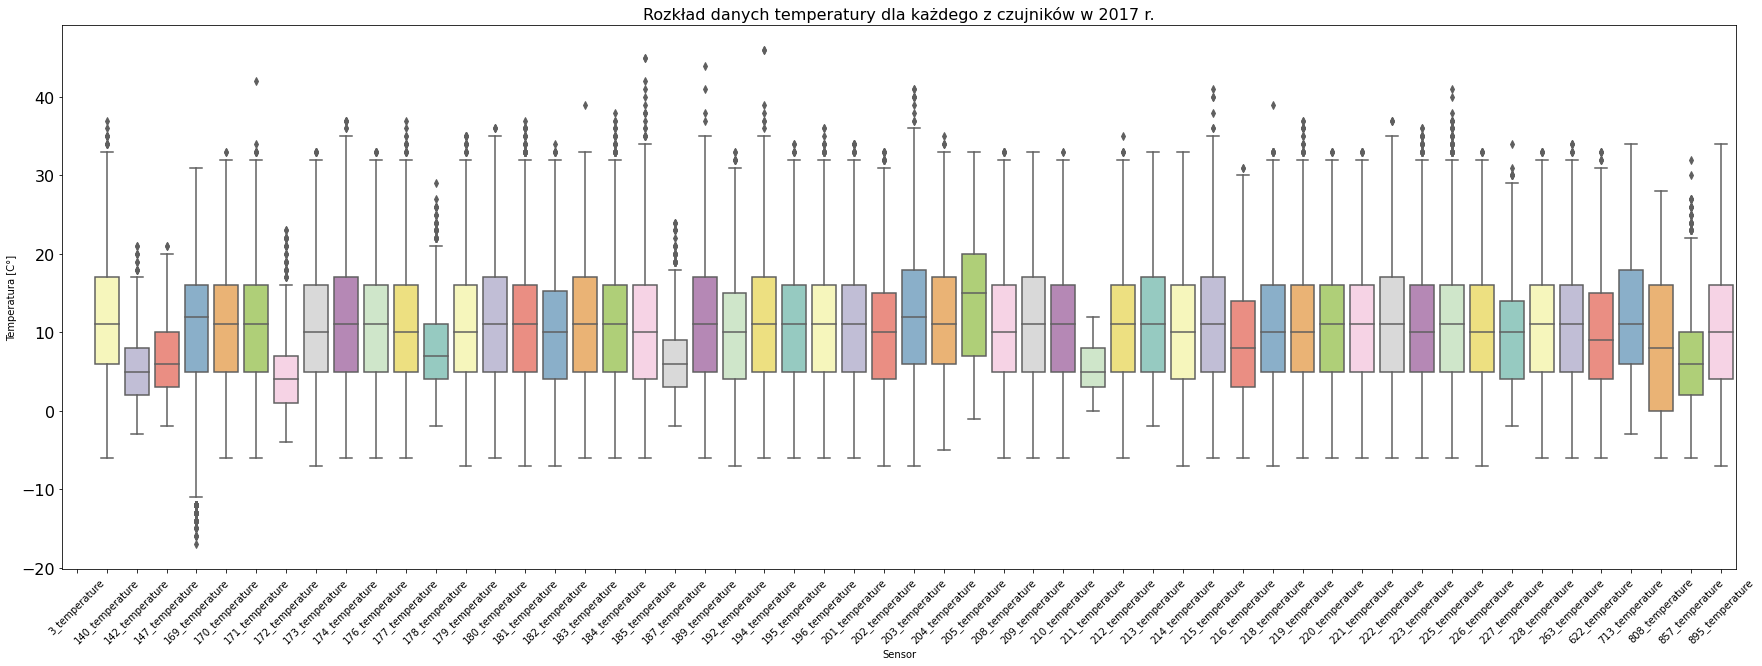

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=temp_col, palette='Set3')
_ = plt.title('Rozkład danych temperatury dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Temperatura [C°]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Na powyższym wykresie widać rozkład temperatur dla poszczególnych czujników bez oczyszczania danych z wartości NaN. Można zauwazyć większe odchylenia dla poszczególnych czujników ale może wynikac to z ich umiejscowienia (miejsca szczególnie nasłoniecznione lub zacienione). Jedynie czujnik nr 3 nie odnotował żadnych wartości w ciągu całego roku.

In [18]:
m = temp_col.mean(axis=1) #Uzupełnianie wartości NaN w wierszach medianą z tego wiersza (z danej godziny dla wszystkich sensorów)
for i, col in enumerate(temp_col):
   temp_col.iloc[:, i] = temp_col.iloc[:, i].fillna(m)

temp_col

,3_temperature,140_temperature,142_temperature,147_temperature,169_temperature,170_temperature,171_temperature,172_temperature,173_temperature,174_temperature,...,225_temperature,226_temperature,227_temperature,228_temperature,263_temperature,622_temperature,713_temperature,808_temperature,857_temperature,895_temperature
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,3.489362,3.489362,3.000000,4.000000,4.000000,4.0,3.0,3.489362,3.0,3.000000,...,3.0,3.0,4.000000,4.0,4.0,3.489362,3.489362,3.489362,3.489362,3.489362
2017-02-28 02:00:00,3.347826,3.347826,3.000000,3.000000,3.000000,4.0,3.0,3.347826,3.0,3.000000,...,3.0,3.0,4.000000,3.0,4.0,3.347826,3.347826,3.347826,3.347826,3.347826
2017-02-28 03:00:00,2.673913,2.673913,2.000000,3.000000,3.000000,3.0,3.0,2.673913,3.0,3.000000,...,2.0,2.0,3.000000,3.0,3.0,2.673913,2.673913,2.673913,2.673913,2.673913
2017-02-28 04:00:00,0.695652,0.695652,0.000000,1.000000,1.000000,1.0,1.0,0.695652,1.0,1.000000,...,0.0,0.0,1.000000,1.0,1.0,0.695652,0.695652,0.695652,0.695652,0.695652
2017-02-28 05:00:00,0.413043,0.413043,0.000000,0.000000,1.000000,1.0,0.0,0.413043,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.413043,0.413043,0.413043,0.413043,0.413043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-24 20:00:00,6.023810,6.000000,6.023810,6.023810,6.023810,6.0,6.0,6.000000,6.0,6.023810,...,6.0,6.0,6.023810,6.0,6.0,6.000000,6.023810,6.000000,6.000000,5.000000
2017-12-24 21:00:00,5.476190,6.000000,5.476190,5.476190,5.476190,6.0,6.0,6.000000,5.0,5.476190,...,6.0,5.0,5.476190,6.0,5.0,6.000000,5.476190,5.000000,5.000000,5.000000
2017-12-24 22:00:00,5.404762,6.000000,5.404762,5.404762,5.404762,6.0,5.0,6.000000,5.0,5.404762,...,6.0,5.0,5.404762,6.0,5.0,6.000000,5.404762,5.000000,5.000000,5.000000


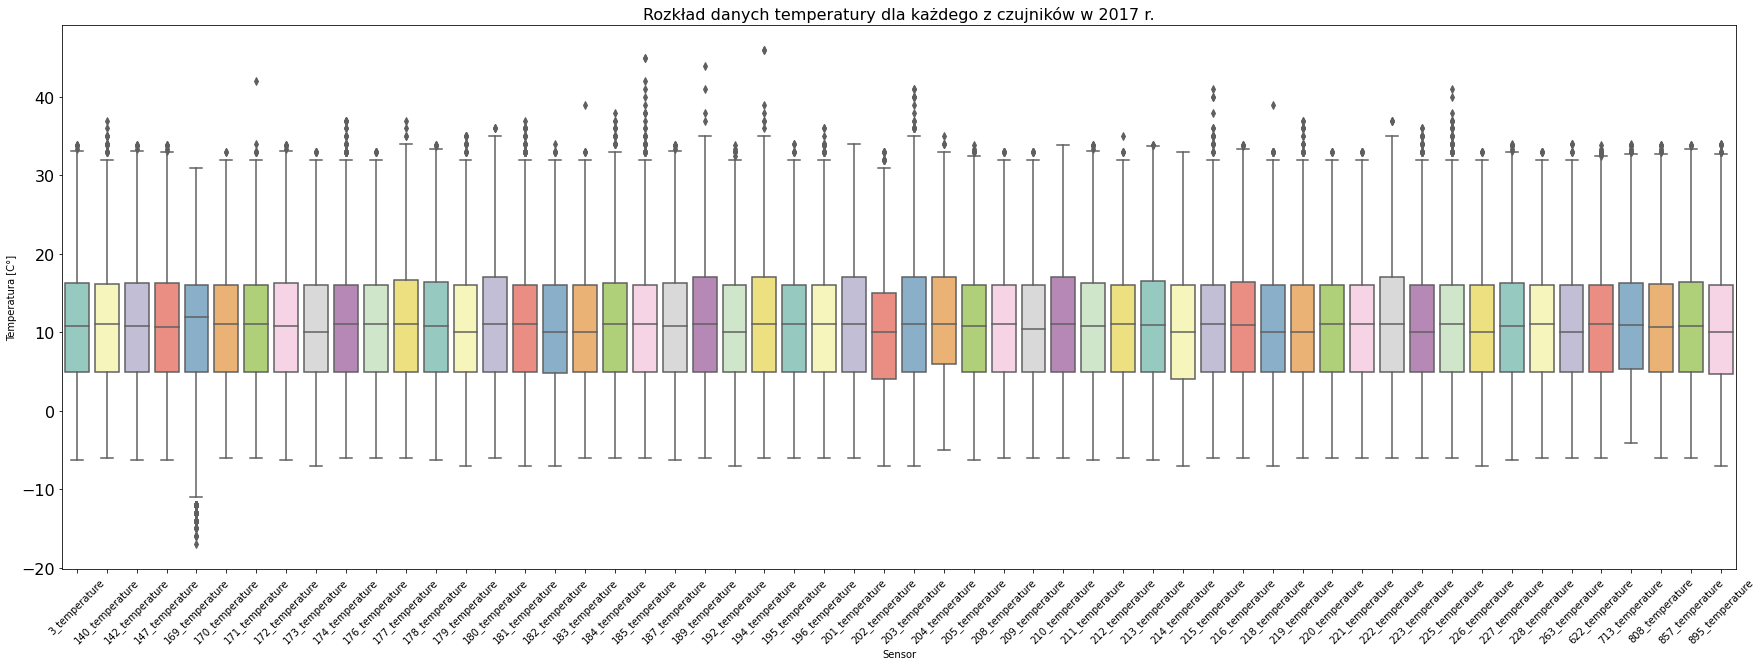

In [19]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=temp_col, palette='Set3')
_ = plt.title('Rozkład danych temperatury dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Temperatura [C°]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Po uzupełnieniu wartości NaN medianami z innych czujników dla danych godzin widać, że czujniki osiągają podobny rozkład, co może świadczyć o ich prawidłowej pracy i braku poważniejszych błędów w pomiarach.

# **Analiza ciśnienia**

In [20]:
pres_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7200 entries, 2017-02-28 01:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   3_pressure    252 non-null    float64
 1   140_pressure  6683 non-null   float64
 2   142_pressure  735 non-null    float64
 3   147_pressure  6573 non-null   float64
 4   169_pressure  6981 non-null   float64
 5   170_pressure  7067 non-null   float64
 6   171_pressure  7122 non-null   float64
 7   172_pressure  7007 non-null   float64
 8   173_pressure  7106 non-null   float64
 9   174_pressure  5998 non-null   float64
 10  176_pressure  1739 non-null   float64
 11  177_pressure  5548 non-null   float64
 12  178_pressure  0 non-null      float64
 13  179_pressure  1573 non-null   float64
 14  180_pressure  1738 non-null   float64
 15  181_pressure  1734 non-null   float64
 16  182_pressure  1701 non-null   float64
 17  183_pressure  954 non-null    float

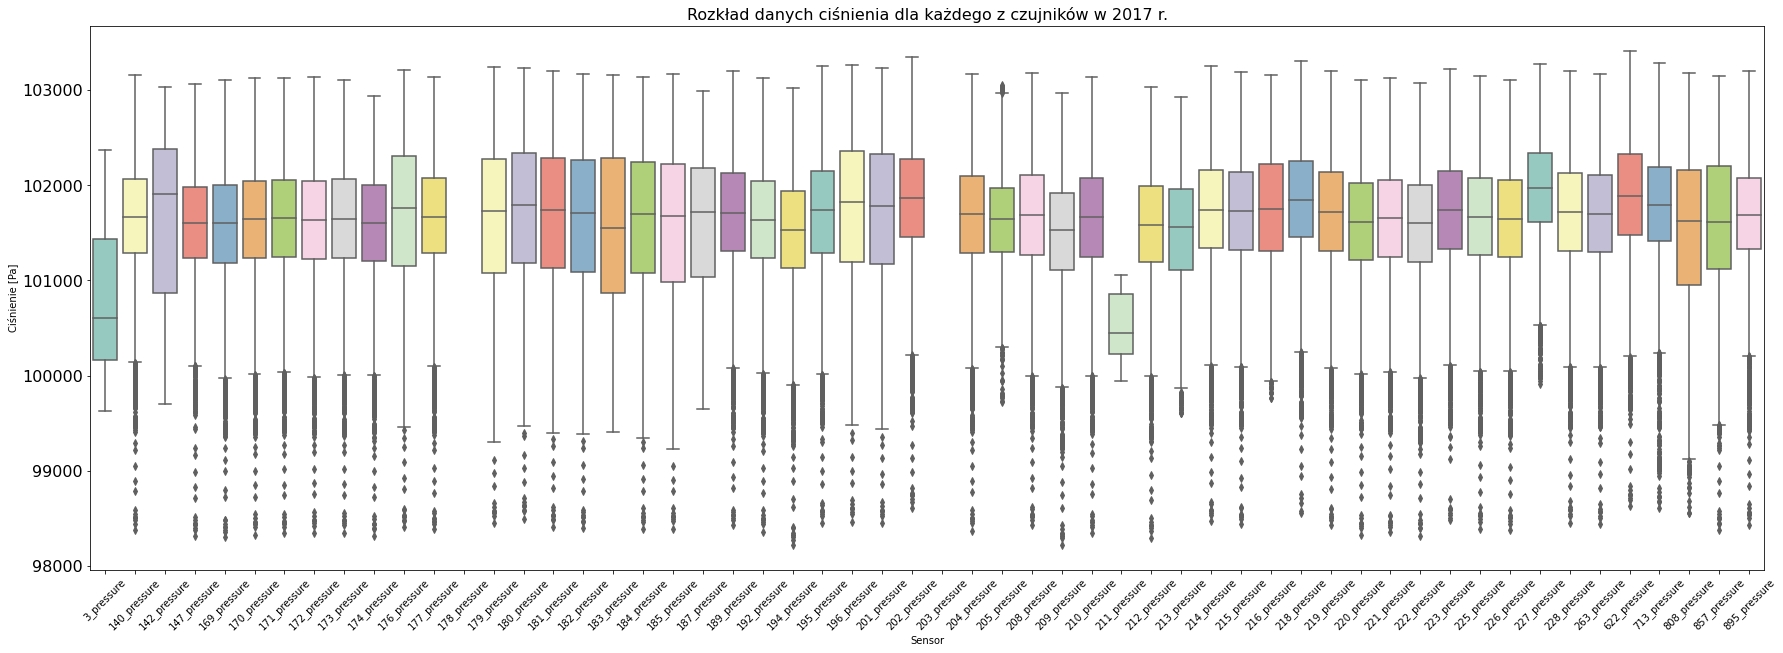

In [21]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=pres_col, palette='Set3')
_ = plt.title('Rozkład danych ciśnienia dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Ciśnienie [Pa]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Podobnie jak w przypadku temperatury, zakres pomiarów z każdego z sensorów jest zbliżony. Również jak poprzednio można zauważyć sensory, które nie dokonały ani jednego pomiaru w ciągu całego roku. 

In [22]:
m = pres_col.mean(axis=1) #Uzupełnianie wartości NaN w wierszach medianą z tego wiersza (z danej godziny dla wszystkich sensorów)
for i, col in enumerate(pres_col):
   pres_col.iloc[:, i] = pres_col.iloc[:, i].fillna(m)

pres_col

,3_pressure,140_pressure,142_pressure,147_pressure,169_pressure,170_pressure,171_pressure,172_pressure,173_pressure,174_pressure,...,225_pressure,226_pressure,227_pressure,228_pressure,263_pressure,622_pressure,713_pressure,808_pressure,857_pressure,895_pressure
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,100169.000000,100358.028571,100378.000000,100262.000000,100328.000000,100313.0,100330.0,100334.0,100326.0,100260.000000,...,100326.0,100324.0,100613.000000,100394.0,100359.0,100358.028571,100358.028571,100358.028571,100358.028571,100358.028571
2017-02-28 02:00:00,100126.000000,100314.771429,100335.000000,100223.000000,100273.000000,100270.0,100285.0,100292.0,100284.0,100221.000000,...,100300.0,100279.0,100571.000000,100352.0,100311.0,100314.771429,100314.771429,100314.771429,100314.771429,100314.771429
2017-02-28 03:00:00,100073.000000,100262.428571,100281.000000,100165.000000,100220.000000,100219.0,100230.0,100240.0,100231.0,100169.000000,...,100250.0,100230.0,100516.000000,100302.0,100260.0,100262.428571,100262.428571,100262.428571,100262.428571,100262.428571
2017-02-28 04:00:00,100014.000000,100204.714286,100219.000000,100107.000000,100161.000000,100160.0,100175.0,100181.0,100174.0,100111.000000,...,100162.0,100170.0,100463.000000,100245.0,100213.0,100204.714286,100204.714286,100204.714286,100204.714286,100204.714286
2017-02-28 05:00:00,99931.000000,100123.771429,100141.000000,100023.000000,100084.000000,100082.0,100093.0,100105.0,100094.0,100033.000000,...,100099.0,100084.0,100380.000000,100159.0,100133.0,100123.771429,100123.771429,100123.771429,100123.771429,100123.771429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-24 20:00:00,101753.463415,101736.000000,101753.463415,101753.463415,101753.463415,101704.0,101691.0,101725.0,101696.0,101753.463415,...,101757.0,101711.0,101753.463415,101781.0,101766.0,101973.000000,101753.463415,101742.000000,101726.000000,101798.000000
2017-12-24 21:00:00,101793.170732,101776.000000,101793.170732,101793.170732,101793.170732,101741.0,101726.0,101765.0,101735.0,101793.170732,...,101801.0,101751.0,101793.170732,101822.0,101813.0,102028.000000,101793.170732,101787.000000,101771.000000,101840.000000
2017-12-24 22:00:00,101800.097561,101785.000000,101800.097561,101800.097561,101800.097561,101738.0,101738.0,101762.0,101734.0,101800.097561,...,101800.0,101763.0,101800.097561,101831.0,101825.0,102047.000000,101800.097561,101786.000000,101788.000000,101839.000000


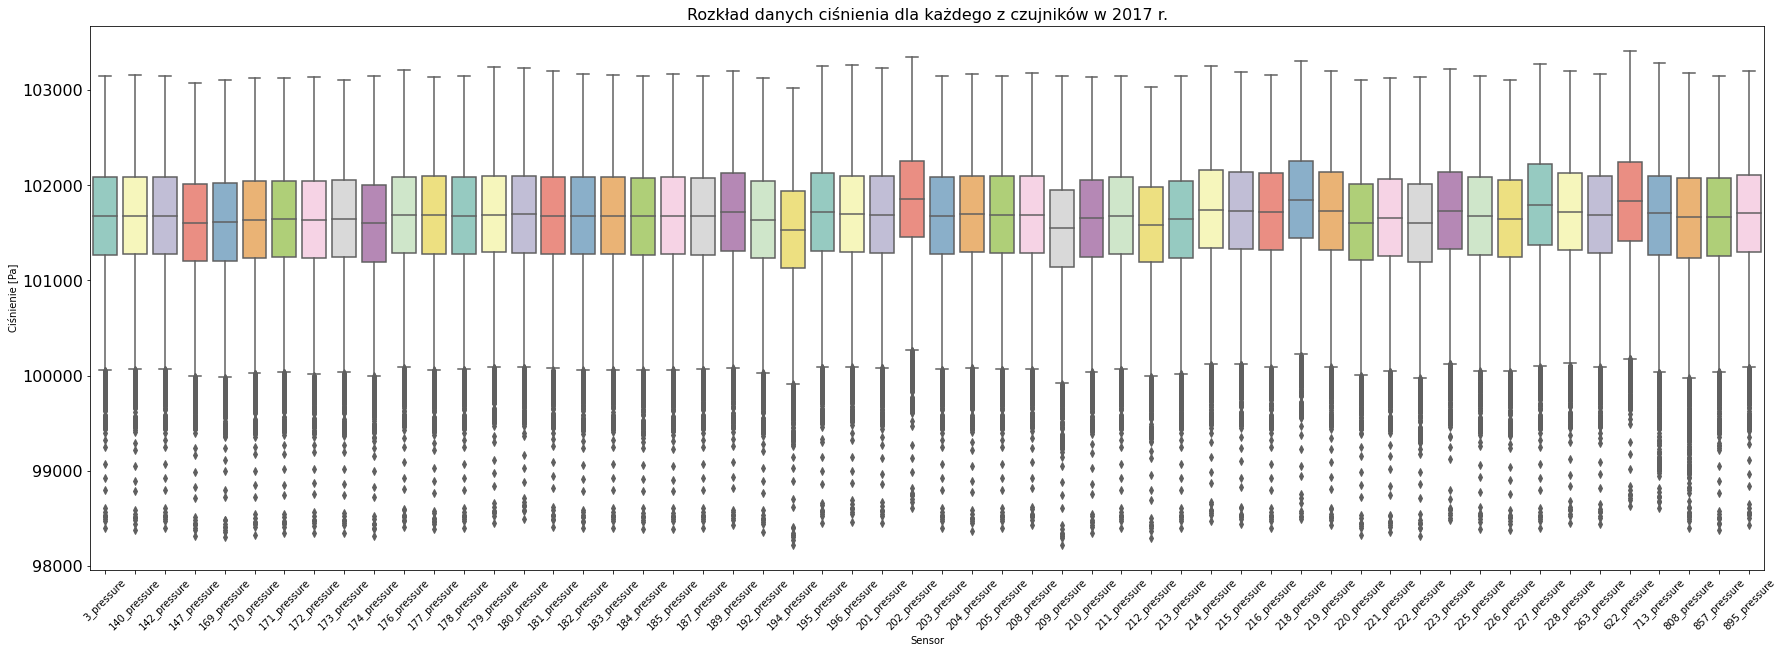

In [23]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=pres_col, palette='Set3')
_ = plt.title('Rozkład danych ciśnienia dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Ciśnienie [Pa]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Uzupełnienie wartości NaN dla ciśnienia przyniosło oczekiwane rezultaty - wszystkie czujniki pokazują bardziej zbliżone wartości, a wieksze różnice mogą wynikac na przykład z wysokości na jakiej są zamotnowane.

# **Analiza wilgotności**


In [24]:
humi_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7200 entries, 2017-02-28 01:00:00 to 2017-12-25 00:00:00
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   3_humidity    0 non-null      float64
 1   140_humidity  6506 non-null   float64
 2   142_humidity  735 non-null    float64
 3   147_humidity  909 non-null    float64
 4   169_humidity  6981 non-null   float64
 5   170_humidity  7067 non-null   float64
 6   171_humidity  7122 non-null   float64
 7   172_humidity  1596 non-null   float64
 8   173_humidity  7006 non-null   float64
 9   174_humidity  5998 non-null   float64
 10  176_humidity  7152 non-null   float64
 11  177_humidity  6414 non-null   float64
 12  178_humidity  1325 non-null   float64
 13  179_humidity  7143 non-null   float64
 14  180_humidity  7192 non-null   float64
 15  181_humidity  7162 non-null   float64
 16  182_humidity  6164 non-null   float64
 17  183_humidity  6731 non-null   float

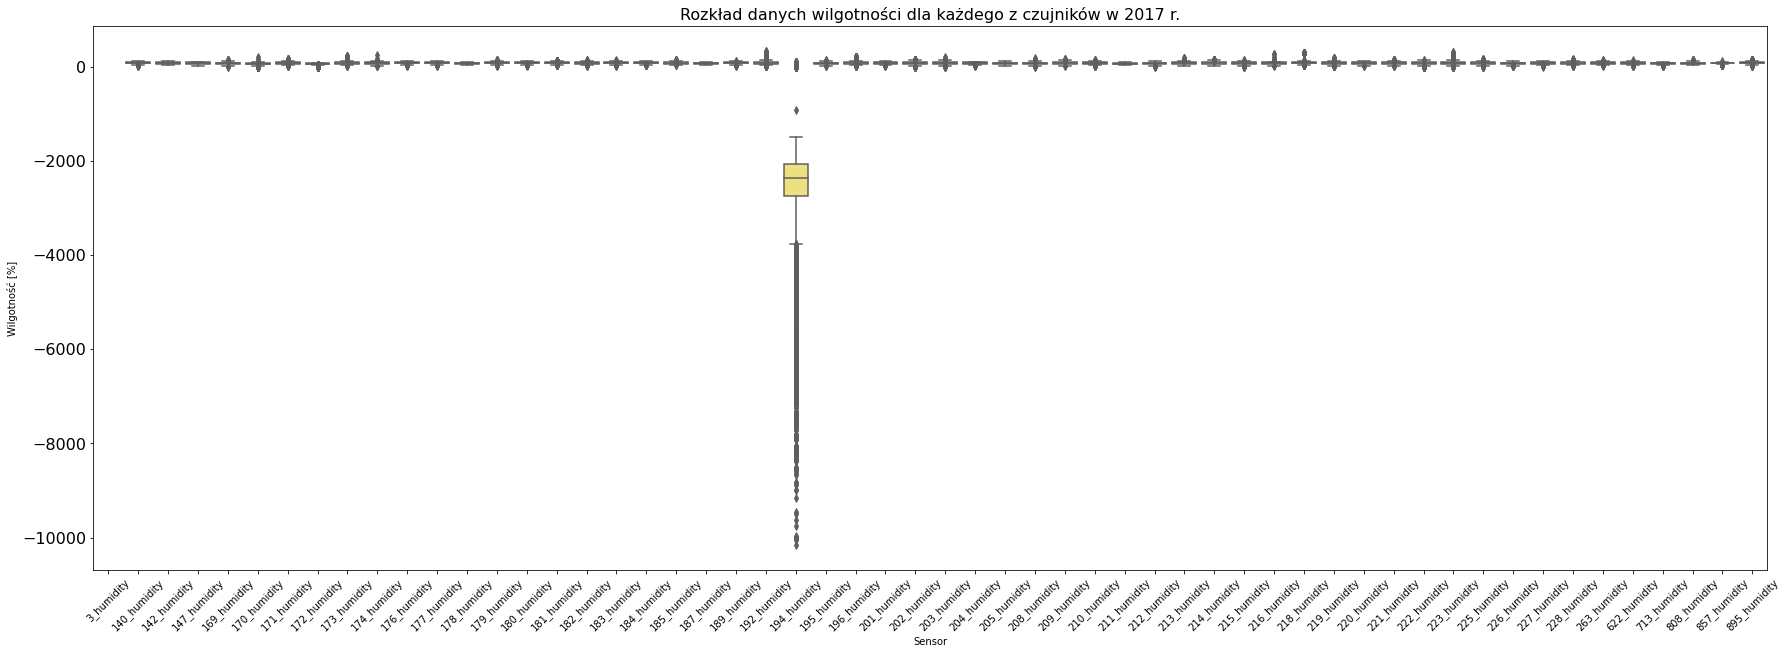

In [25]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=humi_col, palette='Set3')
_ = plt.title('Rozkład danych wilgotności dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Wilgotność [%]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Pierwszy raz można zaobserwować, że jeden z czujników wyraźnie odbiega wynikami pomiaru od innych. Zdecydowanie jest to błąd,  ponieważ wartości ciśnienia mierzy się procentowo w zakresie od 0 do 100 procent. Jeśli uwzględnilibyśmy w uzupełnianiu występujących wartości NaN taki sensor, mógłby on zakłamać uzupełniane metryki. Z uwagi na ten fakt, postanowiliśmy ten sensor usunąć.

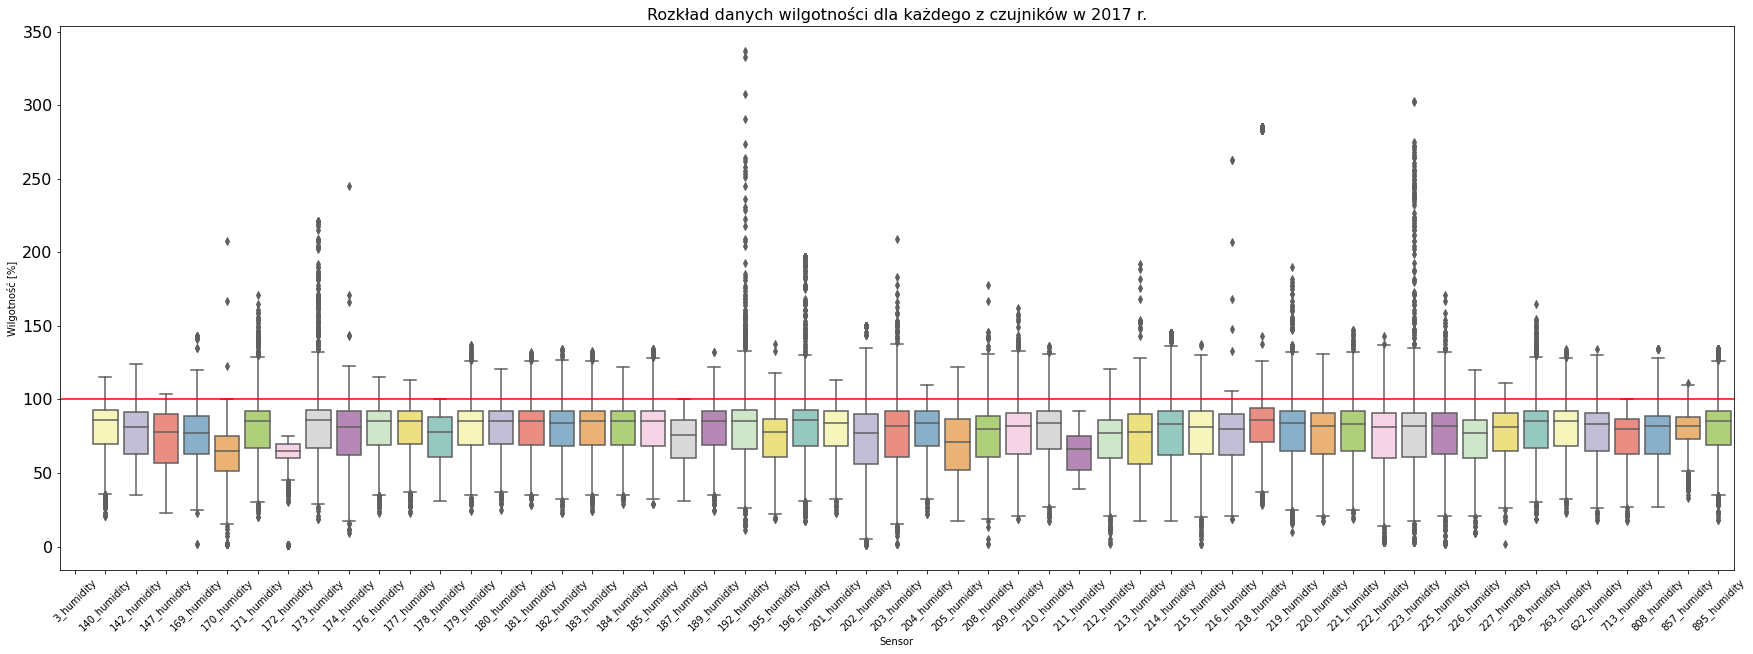

In [26]:
humi_col_without_194 = humi_col.drop(columns='194_humidity')
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=humi_col_without_194, palette='Set3')
_ = plt.title('Rozkład danych wilgotności dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Wilgotność [%]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.axhline(100, color='red')
_ = plt.show()

Niestety ale pozostałe czujniki nadal notują wartości przekraczające 100%. W celu poprawy wyników zastąpimy te obserwacje wartościami median.

In [27]:
sensors_no = ['3_humidity', '140_humidity', '142_humidity', '147_humidity',
       '169_humidity', '170_humidity', '171_humidity', '172_humidity',
       '173_humidity', '174_humidity', '176_humidity', '177_humidity',
       '179_humidity', '180_humidity', '181_humidity', '182_humidity',
       '183_humidity', '184_humidity', '185_humidity', '187_humidity',
       '189_humidity', '192_humidity', '195_humidity', '196_humidity', 
       '201_humidity', '202_humidity', '203_humidity', '204_humidity', 
       '205_humidity', '208_humidity', '209_humidity', '210_humidity', 
       '212_humidity', '213_humidity', '214_humidity', '215_humidity', 
       '216_humidity', '218_humidity', '219_humidity', '220_humidity', 
       '221_humidity', '222_humidity', '223_humidity', '225_humidity', 
       '226_humidity', '227_humidity', '228_humidity', '263_humidity', 
       '622_humidity', '713_humidity', '808_humidity', '857_humidity', 
       '895_humidity']

In [28]:
for sensor in sensors_no:
  humi_col_without_194.loc[humi_col_without_194[sensor]>100,[sensor]] = np.NaN

In [29]:
m = humi_col_without_194.mean(axis=1) #Uzupełnianie wartości NaN w wierszach medianą z tego wiersza (z danej godziny dla wszystkich sensorów)
for i, col in enumerate(humi_col_without_194):
   humi_col_without_194.iloc[:, i] = humi_col_without_194.iloc[:, i].fillna(m)

humi_col_without_194

,3_humidity,140_humidity,142_humidity,147_humidity,169_humidity,170_humidity,171_humidity,172_humidity,173_humidity,174_humidity,...,225_humidity,226_humidity,227_humidity,228_humidity,263_humidity,622_humidity,713_humidity,808_humidity,857_humidity,895_humidity
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,73.000000,73.000000,78.000000,71.000000,75.000000,73.0,73.0,73.000000,72.0,71.000000,...,70.0,74.0,72.000000,73.0,76.0,73.000000,73.000000,73.000000,73.000000,73.000000
2017-02-28 02:00:00,74.533333,74.533333,80.000000,73.000000,76.000000,75.0,75.0,74.533333,74.0,73.000000,...,72.0,76.0,73.000000,74.0,78.0,74.533333,74.533333,74.533333,74.533333,74.533333
2017-02-28 03:00:00,69.377778,69.377778,74.000000,68.000000,72.000000,69.0,69.0,69.377778,68.0,67.000000,...,67.0,69.0,67.000000,68.0,71.0,69.377778,69.377778,69.377778,69.377778,69.377778
2017-02-28 04:00:00,79.200000,79.200000,84.000000,79.000000,84.000000,79.0,80.0,79.200000,79.0,78.000000,...,77.0,80.0,77.000000,78.0,80.0,79.200000,79.200000,79.200000,79.200000,79.200000
2017-02-28 05:00:00,75.977778,75.977778,79.000000,75.000000,82.000000,75.0,84.0,75.977778,75.0,73.000000,...,73.0,75.0,72.000000,73.0,75.0,75.977778,75.977778,75.977778,75.977778,75.977778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-24 20:00:00,84.268293,87.000000,84.268293,84.268293,84.268293,63.0,88.0,63.000000,88.0,84.268293,...,88.0,77.0,84.268293,88.0,85.0,88.000000,84.268293,85.000000,79.000000,85.000000
2017-12-24 21:00:00,84.463415,88.000000,84.463415,84.463415,84.463415,63.0,88.0,63.000000,88.0,84.463415,...,88.0,78.0,84.463415,88.0,85.0,88.000000,84.463415,86.000000,79.000000,85.000000
2017-12-24 22:00:00,81.560976,85.000000,81.560976,81.560976,81.560976,61.0,85.0,61.000000,85.0,81.560976,...,85.0,75.0,81.560976,85.0,83.0,85.000000,81.560976,83.000000,76.000000,82.000000


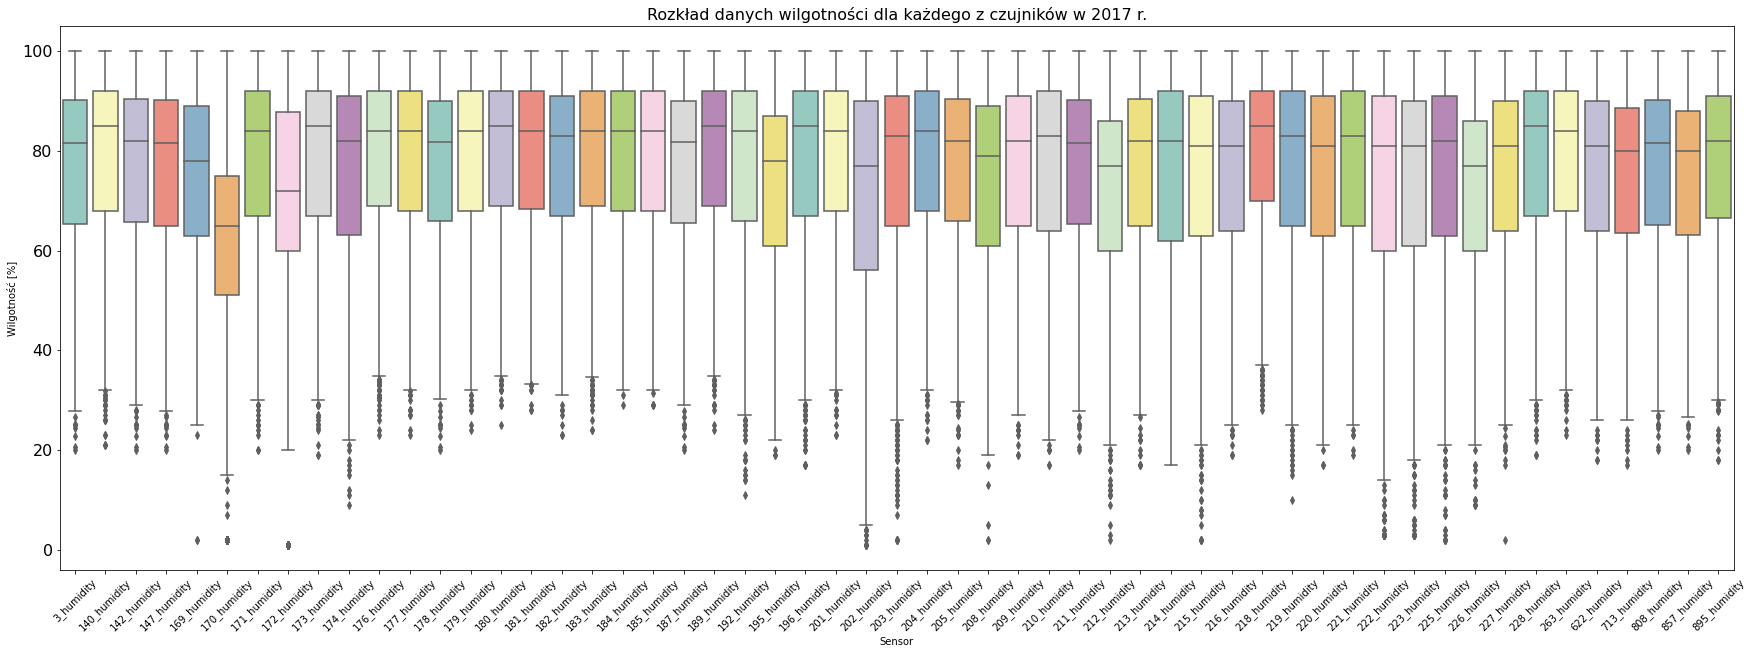

In [30]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = sns.boxplot(data=humi_col_without_194, palette='Set3')
_ = plt.title('Rozkład danych wilgotności dla każdego z czujników w 2017 r.', fontsize =16)
_ = plt.xlabel('Sensor')
_ = plt.ylabel('Wilgotność [%]')
_ = plt.yticks(fontsize=16)
_ = plt.xticks(fontsize=10,rotation = 45)
_ = plt.show()

Po wyczyszczeniu danych otrzymaliśmy wykres z pomiarami bez zauważalnych błędów.

# **Analiza stężenia pyłów PM1, PM2,5 oraz PM10**

Czujniki, które znajdują się w zbiorze danych, posiadają wartości dla PM1, PM2,5 oraz dla PM10. Skrót PM pochodzi od ang. Particulate Matter i oznacza on drobne cząsteczki swobodnie unoszące się w powietrzu (stanowiące część tzw. aerozolu atmosferycznego). Mogą być pochodzenia naturalnego – np. pył mineralny, aerozol morski, popioły wulkaniczne itp. ale mogą również stanowić produkt działalności człowieka. Do tej grupy należą np. drobne cząsteczki sadzy powstające w procesie spalania węgla lub innych paliw, czy też cząsteczki pyłu wtórnego, powstające w wyniku przekształceń innych zanieczyszczeń obecnych w powietrzu, np. tlenków siarki i azotu. Dobowa dopuszczalna wartość dla stężenia PM10 w Polsce to 50 µg/m3 (średnia z 24 godzin), natomiast roczna to 40µg/m3 (wartość dopuszczalna średnioroczna). W Unii Europejskiej roczne dopuszczalne stężenie to również 40µg/m3, lecz dopuszczalne przez WHO to już tylko 20µg/m3. Wartość dopuszczalna średnioroczna dla PM2,5 to 25 µg/m3 (wg WHO. Z uwagi na nieskalibrowany pomiar dla pyłu PM1 skupimy się na pozostałych.

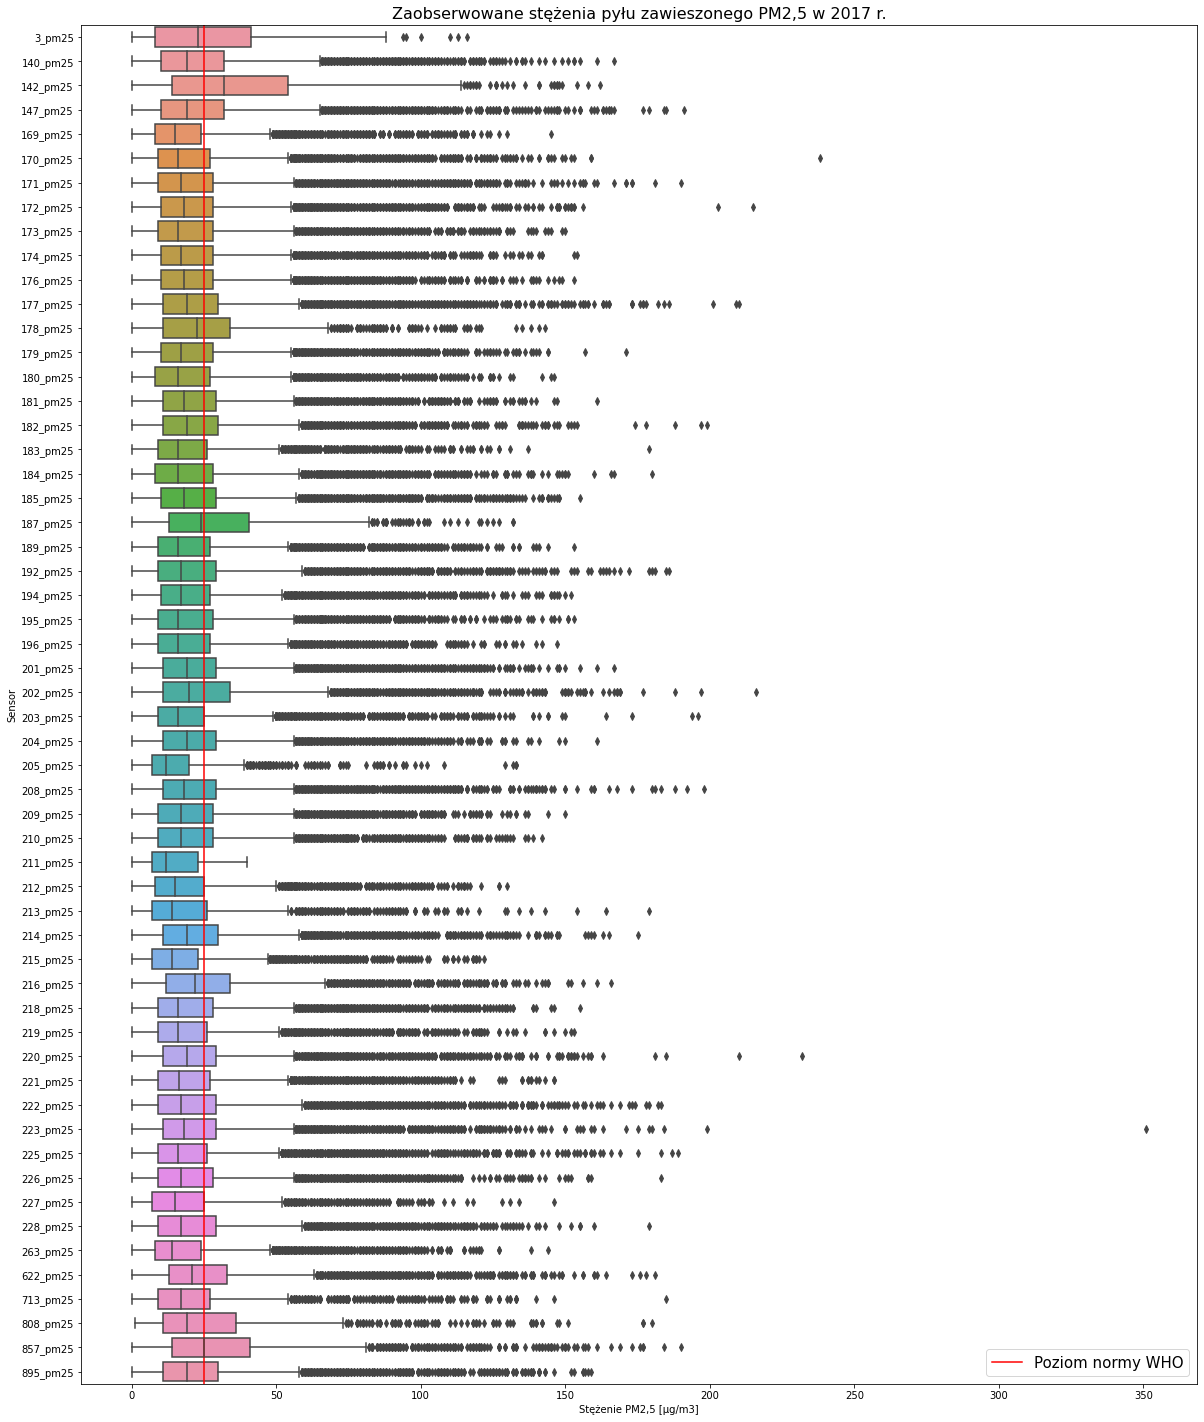

In [31]:
fig, ax = plt.subplots(figsize=(20, 25))
ax = sns.boxplot(data=pm25_col, orient='h')
_ = plt.title('Zaobserwowane stężenia pyłu zawieszonego PM2,5 w 2017 r.', fontsize=16)
_ = plt.axvline(25, color='red', label = 'Poziom normy WHO')
_ = plt.ylabel('Sensor')
_ = plt.xlabel('Stężenie PM2,5 [µg/m3]')
_ = plt.legend(loc="lower right", prop={'size': 15})
_ = plt.show()

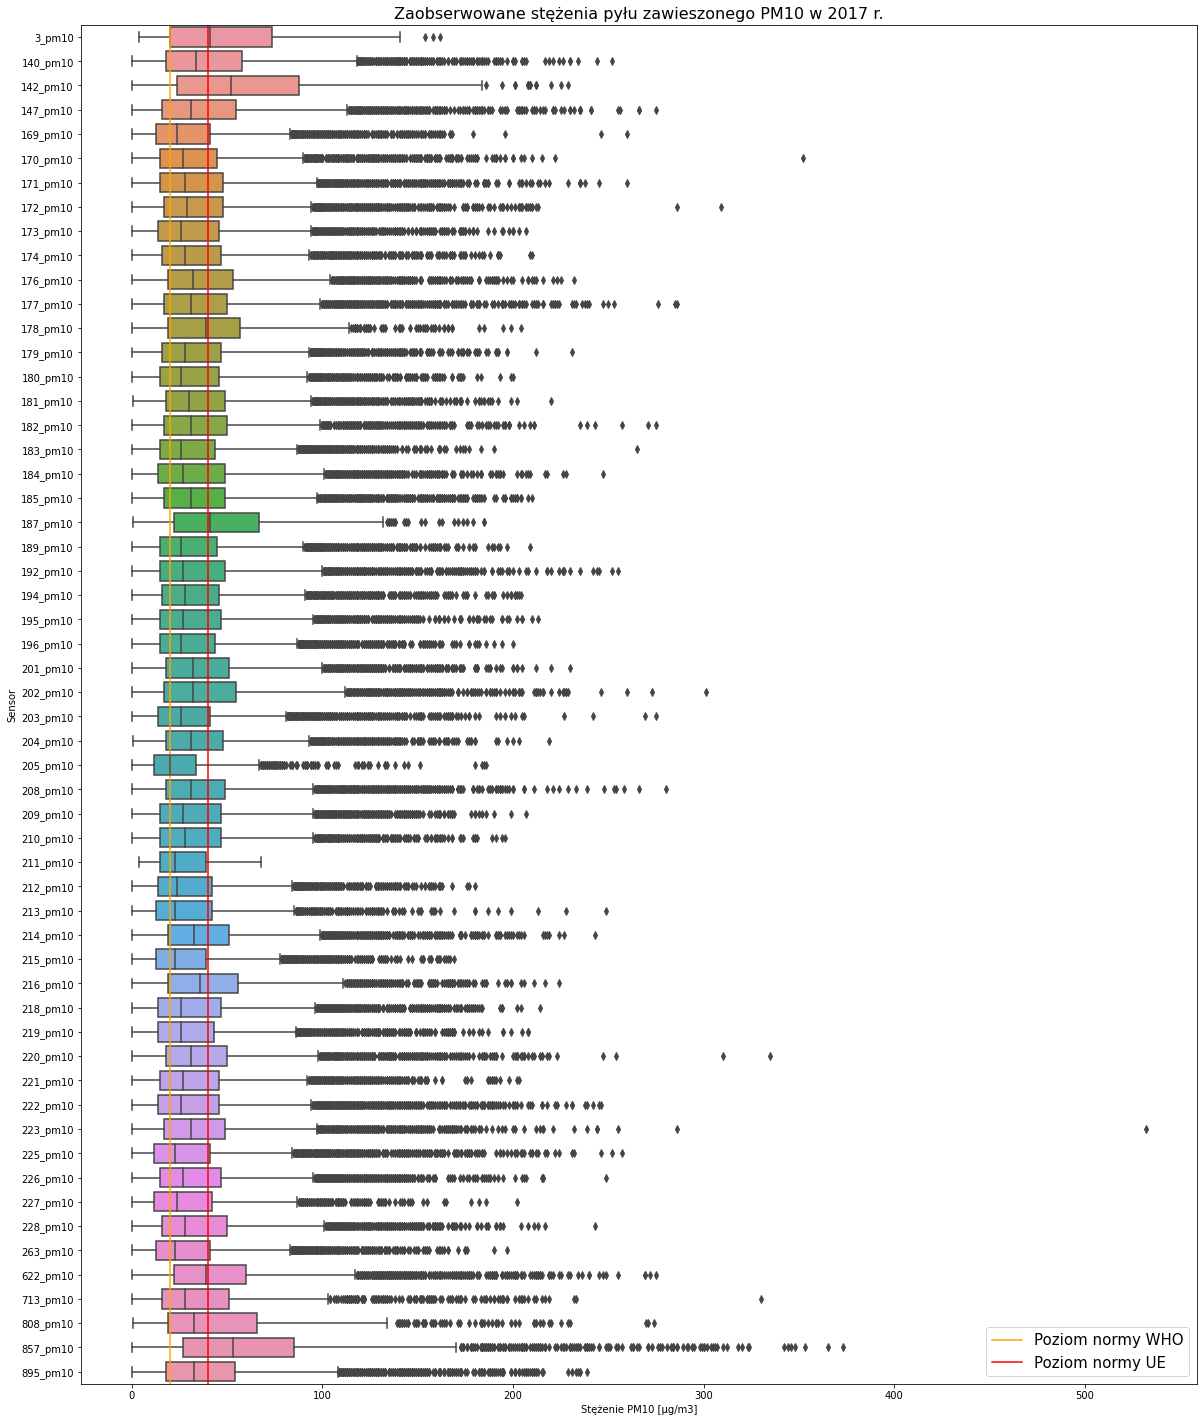

In [32]:
fig, ax = plt.subplots(figsize=(20, 25))
ax = sns.boxplot(data=pm10_col, orient='h')
_ = plt.title('Zaobserwowane stężenia pyłu zawieszonego PM10 w 2017 r.', fontsize=16)
_ = plt.axvline(20, color='orange', label = 'Poziom normy WHO')
_ = plt.axvline(40, color='red', label = 'Poziom normy UE')
_ = plt.ylabel('Sensor')
_ = plt.xlabel('Stężenie PM10 [µg/m3]')
_ = plt.legend(loc="lower right", prop={'size': 15})
_ = plt.show()

Na powyższych wykresach widać, że steżenie PM2,5 i PM10 jest wielokrotnie przekraczane. Wiemy, że smog wzmaga się zimową porą, lecz nie mamy wszystkich danych z dwóch pierwszych miesiecy jak i w grudniu także brakuje nam danych. Dlatego sprawdzimy jak wygląda średnie stężenie godzinowe PM10 w listopadzie.

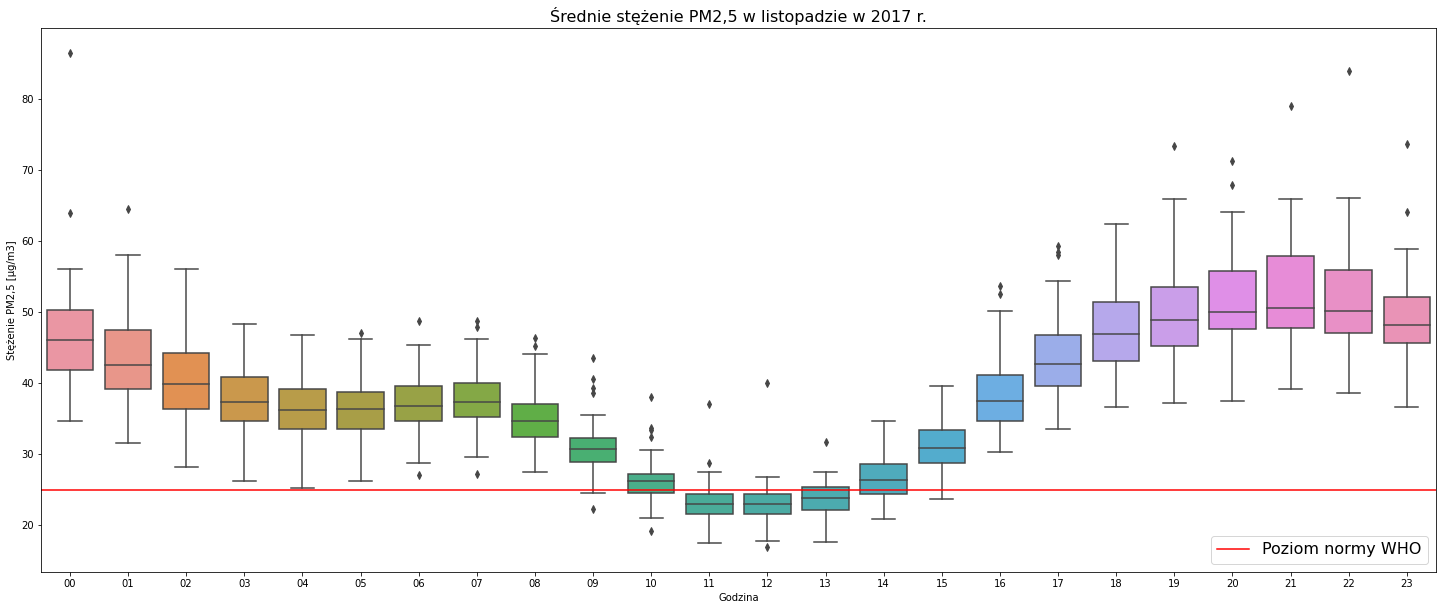

In [33]:
nov = pd.read_csv('/content/november-2017.csv')
nov['UTC time'] = pd.to_datetime(nov['UTC time'])
nov_col_pm25 = [col for col in nov.columns if 'pm25' in col or 'UTC time' in col]
nov_pm25 = nov[nov_col_pm25]
nov['UTC time'] = nov['UTC time'].dt.strftime('%H')
nov_pm25_means = nov[nov_col_pm25].groupby('UTC time').mean()
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.boxplot(data=nov_pm25_means.T)
_ = plt.title('Średnie stężenie PM2,5 w listopadzie w 2017 r.', fontsize=16)
_ = plt.axhline(25, label = 'Poziom normy WHO', color='red')
_ = plt.xlabel('Godzina')
_ = plt.ylabel('Stężenie PM2,5 [µg/m3]')
_ = plt.legend(loc='lower right', fontsize=16)
_ = plt.show()

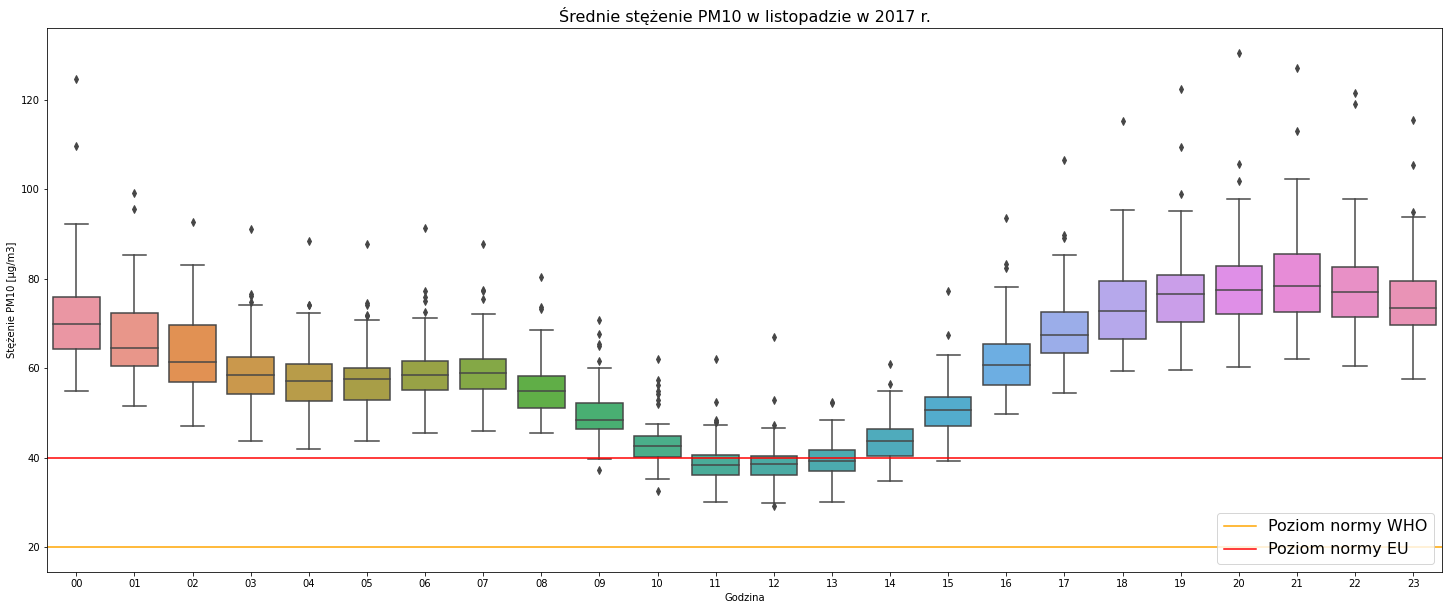

In [34]:
nov = pd.read_csv('/content/november-2017.csv')
nov['UTC time'] = pd.to_datetime(nov['UTC time'])
nov_col_pm10 = [col for col in nov.columns if 'pm10' in col or 'UTC time' in col]
nov_pm10 = nov[nov_col_pm10]
nov['UTC time'] = nov['UTC time'].dt.strftime('%H')
nov_pm10_means = nov[nov_col_pm10].groupby('UTC time').mean()
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.boxplot(data=nov_pm10_means.T)
_ = plt.title('Średnie stężenie PM10 w listopadzie w 2017 r.', fontsize=16)
_ = plt.axhline(20, label = 'Poziom normy WHO', color='orange')
_ = plt.axhline(40, label = 'Poziom normy EU', color='red')
_ = plt.xlabel('Godzina')
_ = plt.ylabel('Stężenie PM10 [µg/m3]')
_ = plt.legend(loc='lower right', fontsize=16)
_ = plt.show()

Na powyższych wykresach widać wyraźnie wyższe steżenie obu pyłów w nocy, co w głównej mierze spowodowane jest niższą temperaturą, a co za tym idzie zwiększoną produkcją zanieczyszczeń pochodzacych z źródeł ogrzewania. Dla porównania sprawdziliśmy także jakie wartości stężenia PM2,5 i PM10 występują w okresie letnim, wybierając do badania lipiec.

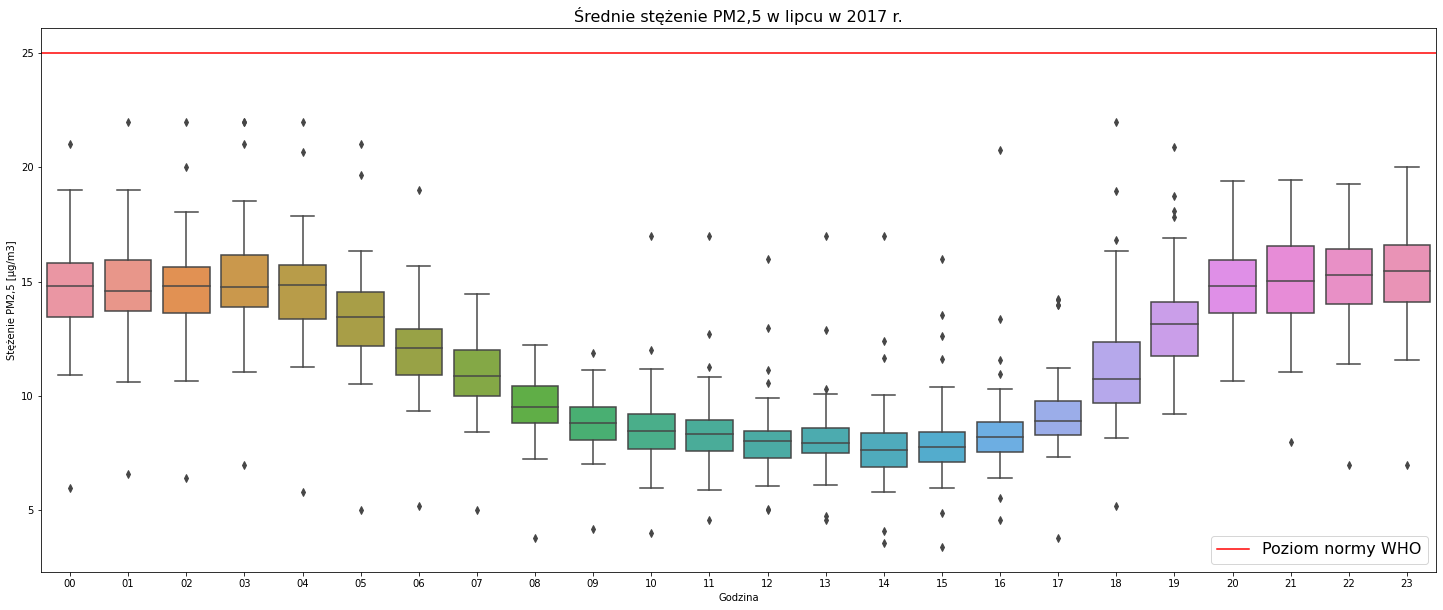

In [35]:
jul = pd.read_csv('/content/july-2017.csv')
jul['UTC time'] = pd.to_datetime(jul['UTC time'])
jul_col_pm25 = [col for col in jul.columns if 'pm25' in col or 'UTC time' in col]
jul_pm25 = jul[jul_col_pm25]
jul['UTC time'] = jul['UTC time'].dt.strftime('%H')
jul_pm25_means = jul[jul_col_pm25].groupby('UTC time').mean()
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.boxplot(data=jul_pm25_means.T)
_ = plt.title('Średnie stężenie PM2,5 w lipcu w 2017 r.', fontsize=16)
_ = plt.axhline(25, label = 'Poziom normy WHO', color='red')
_ = plt.xlabel('Godzina')
_ = plt.ylabel('Stężenie PM2,5 [µg/m3]')
_ = plt.legend(loc='lower right', fontsize=16)
_ = plt.show()

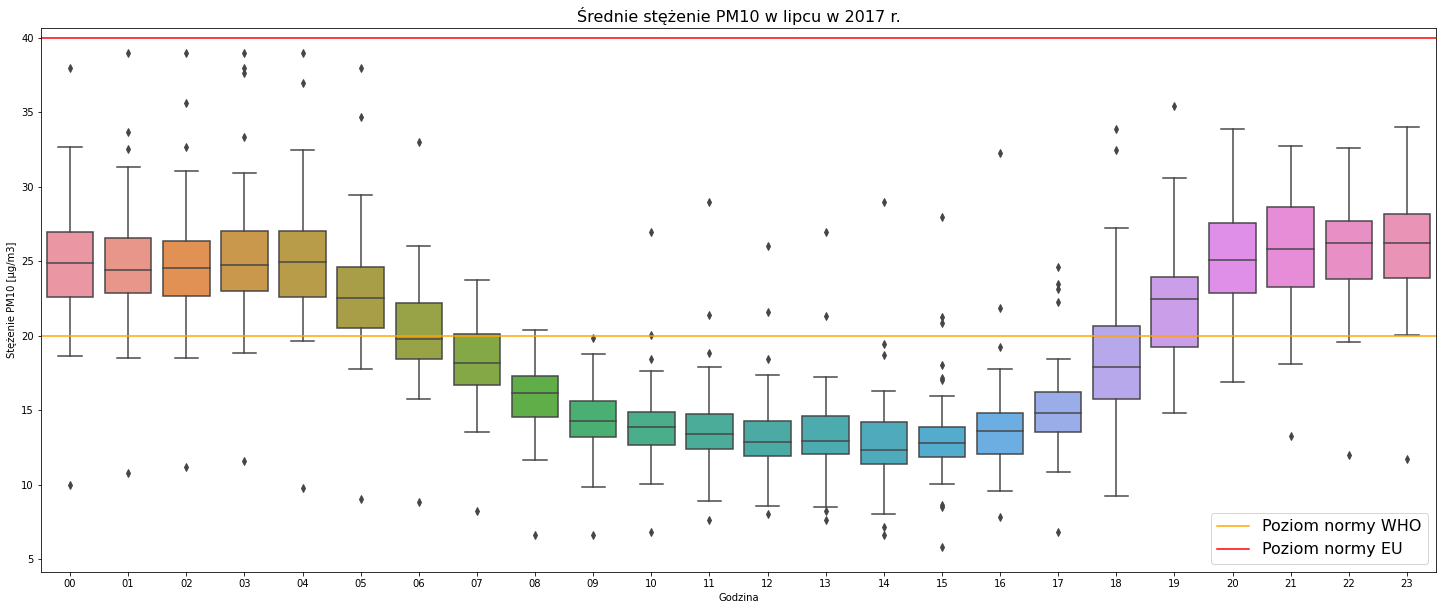

In [36]:
jul = pd.read_csv('/content/july-2017.csv')
jul['UTC time'] = pd.to_datetime(jul['UTC time'])
jul_col_pm10 = [col for col in jul.columns if 'pm10' in col or 'UTC time' in col]
jul_pm10 = jul[jul_col_pm10]
jul['UTC time'] = jul['UTC time'].dt.strftime('%H')
jul_pm10_means = jul[jul_col_pm10].groupby('UTC time').mean()
fig, ax = plt.subplots(figsize=(25, 10))
ax = sns.boxplot(data=jul_pm10_means.T)
_ = plt.title('Średnie stężenie PM10 w lipcu w 2017 r.', fontsize=16)
_ = plt.axhline(20, label = 'Poziom normy WHO', color='orange')
_ = plt.axhline(40, label = 'Poziom normy EU', color='red')
_ = plt.xlabel('Godzina')
_ = plt.ylabel('Stężenie PM10 [µg/m3]')
_ = plt.legend(loc='lower right', fontsize=16)
_ = plt.show()

Z powyższych wykresów można wywnioskować, że w lipcu stężenie dla obu pyłów jest znacznie niższe niż w listopadzie. Nie mniej jednak, nawet w lipcu stężenie pyłów PM10 nie mieści się zawsze w normie WHO.

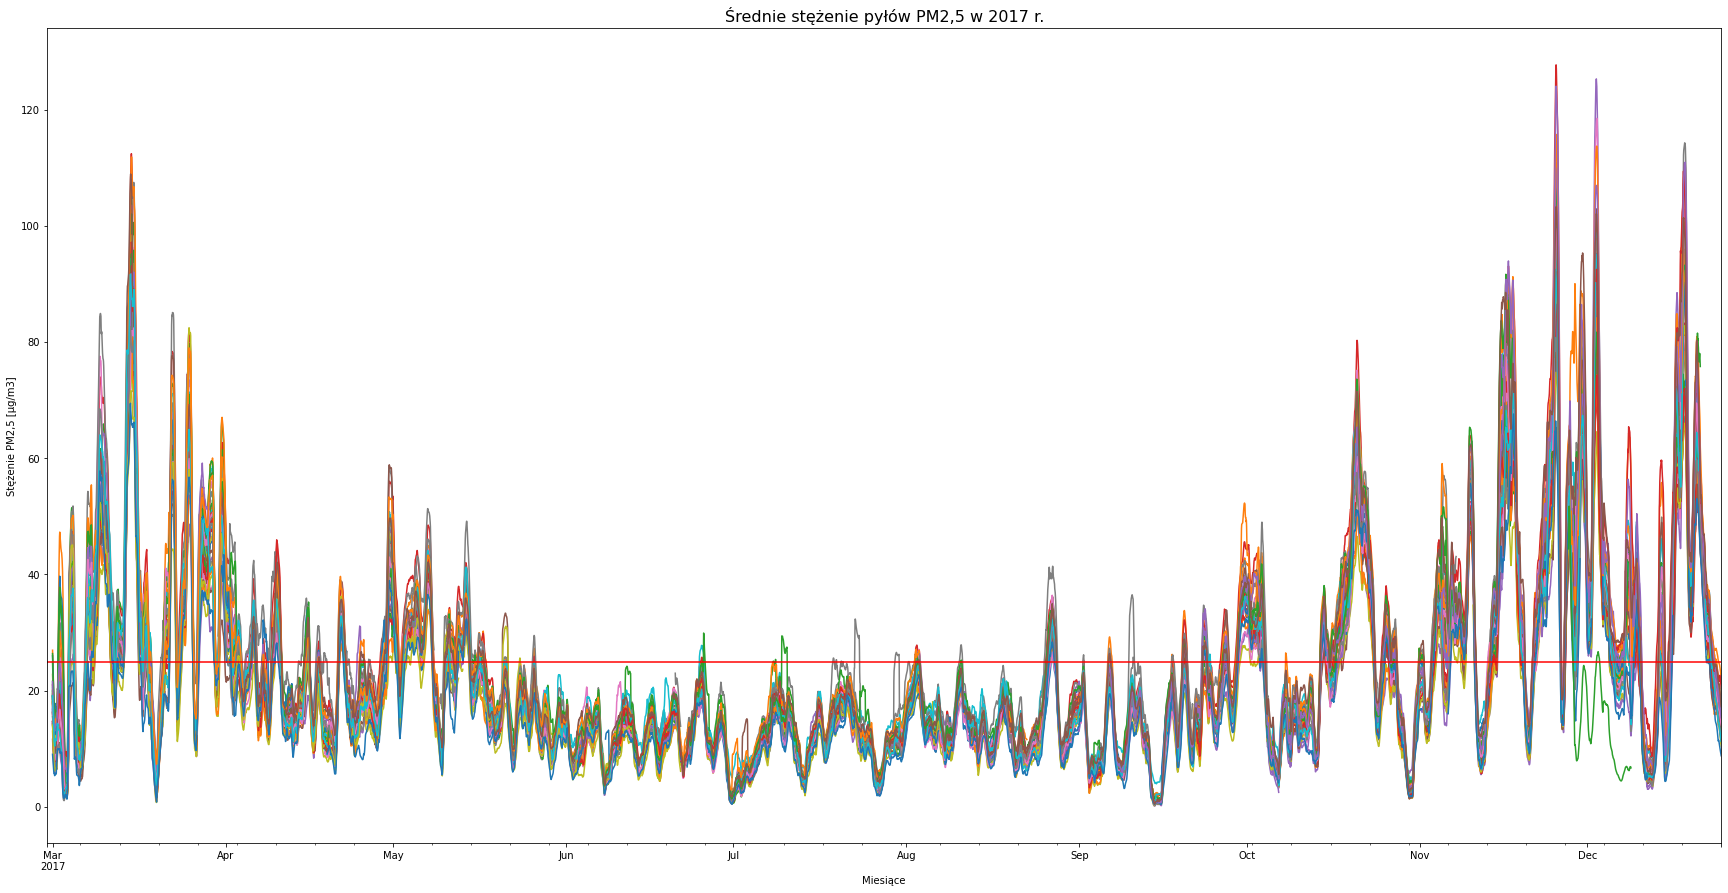

In [37]:
moving_average_pm25_col = pm25_col.rolling(window=24).mean() #Średnia ruchoma dniowa dla poszczególnych czujników

_ = moving_average_pm25_col.plot(figsize =(30,15), legend=None)
_ = plt.title('Średnie stężenie pyłów PM2,5 w 2017 r.', fontsize =16)
_ = plt.axhline(25, label = 'Poziom normy WHO', color='red')
_ = plt.xlabel('Miesiące')
_ = plt.ylabel('Stężenie PM2,5 [µg/m3]')
_ = plt.show()

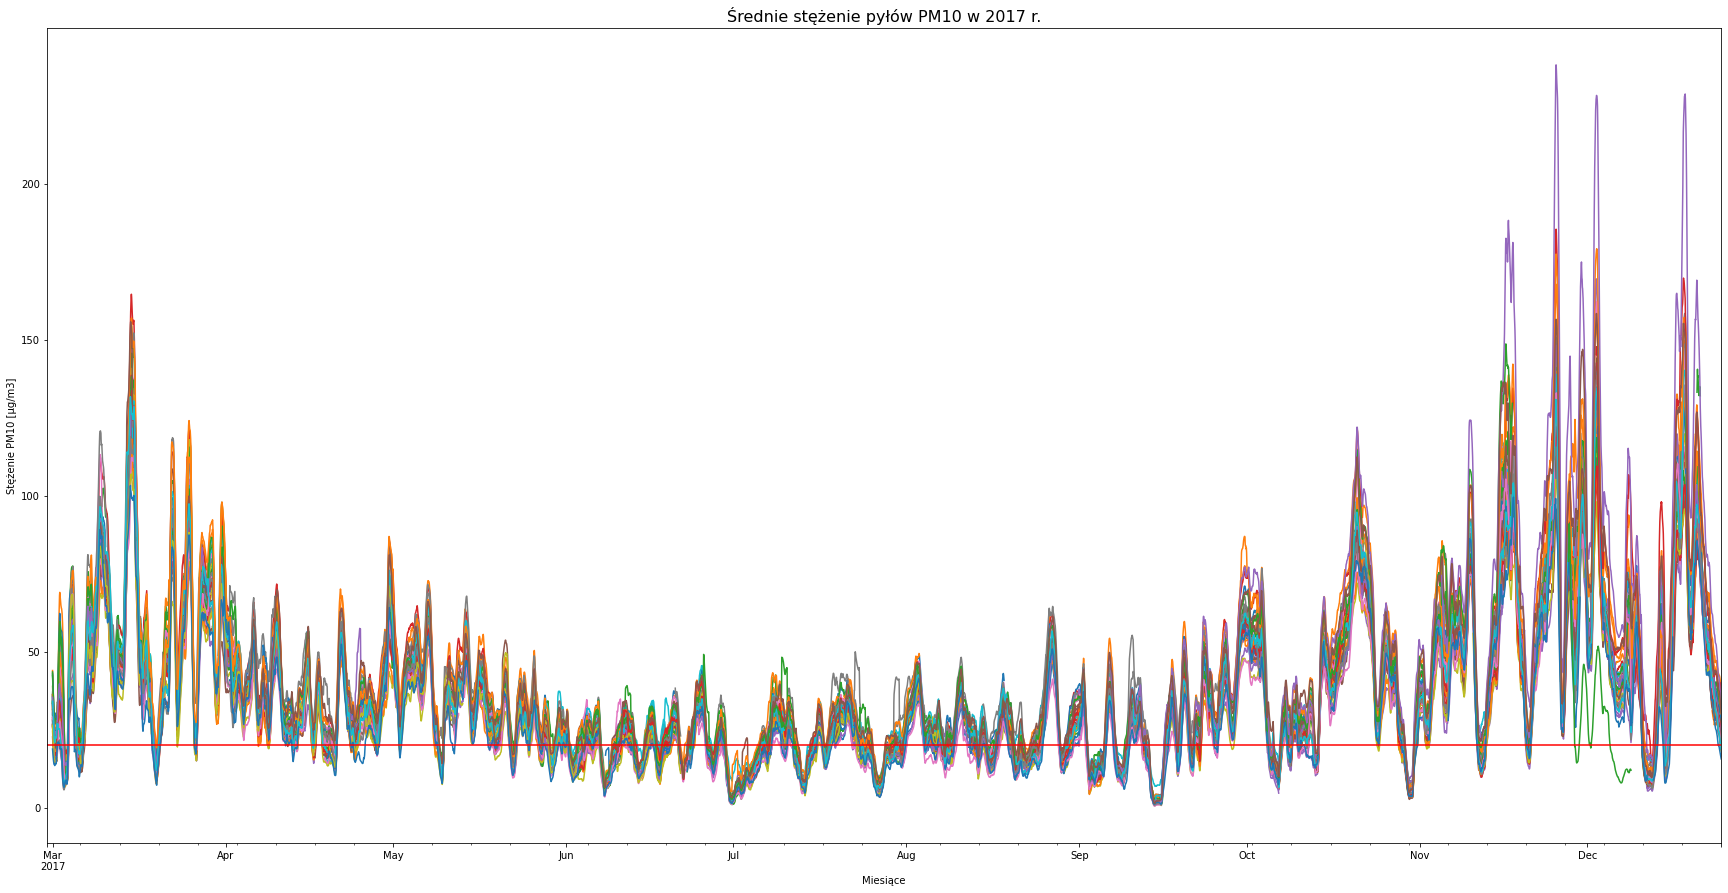

In [38]:
moving_average_pm10_col = pm10_col.rolling(window=24).mean() #Średnia ruchoma dniowa dla poszczególnych czujników

_ = moving_average_pm10_col.plot(figsize =(30,15), legend=None)
_ = plt.title("Średnie stężenie pyłów PM10 w 2017 r.", fontsize =16)
_ = plt.axhline(20, label = "Poziom normy WHO", color="red")
_ = plt.xlabel("Miesiące")
_ = plt.ylabel('Stężenie PM10 [µg/m3]')
_ = plt.show()

Powyższe wykresy również potwierdzają, że stężenie mierzonych pyłów zawieszonych jest najwyższe w okresie zimowym.

# **Przygotowywanie danych do dalszej analizy**

In [39]:
#Połączenie nowych DF po wyczyszczeniu danych w całość
y2017 = temp_col.copy()
y2017 = pd.concat([y2017,pres_col],axis=1)
y2017 = pd.concat([y2017,humi_col_without_194],axis=1)
y2017 = pd.concat([y2017,pm1_col],axis=1)
y2017 = pd.concat([y2017,pm25_col],axis=1)
y2017 = pd.concat([y2017,pm10_col],axis=1)

y2017

,3_temperature,140_temperature,142_temperature,147_temperature,169_temperature,170_temperature,171_temperature,172_temperature,173_temperature,174_temperature,...,225_pm10,226_pm10,227_pm10,228_pm10,263_pm10,622_pm10,713_pm10,808_pm10,857_pm10,895_pm10
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,3.489362,3.489362,3.000000,4.000000,4.000000,4.0,3.0,3.489362,3.0,3.000000,...,51.0,35.0,38.0,40.0,28.0,NaN,NaN,NaN,NaN,NaN
2017-02-28 02:00:00,3.347826,3.347826,3.000000,3.000000,3.000000,4.0,3.0,3.347826,3.0,3.000000,...,50.0,35.0,43.0,45.0,25.0,NaN,NaN,NaN,NaN,NaN
2017-02-28 03:00:00,2.673913,2.673913,2.000000,3.000000,3.000000,3.0,3.0,2.673913,3.0,3.000000,...,46.0,45.0,44.0,50.0,30.0,NaN,NaN,NaN,NaN,NaN
2017-02-28 04:00:00,0.695652,0.695652,0.000000,1.000000,1.000000,1.0,1.0,0.695652,1.0,1.000000,...,43.0,51.0,49.0,49.0,25.0,NaN,NaN,NaN,NaN,NaN
2017-02-28 05:00:00,0.413043,0.413043,0.000000,0.000000,1.000000,1.0,0.0,0.413043,0.0,0.000000,...,45.0,51.0,56.0,52.0,18.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-24 20:00:00,6.023810,6.000000,6.023810,6.023810,6.023810,6.0,6.0,6.000000,6.0,6.023810,...,22.0,19.0,NaN,18.0,15.0,29.0,NaN,43.0,31.0,26.0
2017-12-24 21:00:00,5.476190,6.000000,5.476190,5.476190,5.476190,6.0,6.0,6.000000,5.0,5.476190,...,20.0,20.0,NaN,18.0,15.0,27.0,NaN,25.0,29.0,23.0
2017-12-24 22:00:00,5.404762,6.000000,5.404762,5.404762,5.404762,6.0,5.0,6.000000,5.0,5.404762,...,17.0,17.0,NaN,16.0,12.0,23.0,NaN,22.0,26.0,21.0


In [41]:
y2017['index1'] = y2017.index
y2017 = y2017.reset_index()
y2017 = y2017.iloc[: , :-1]

In [42]:
y2017 = pd.melt(y2017, id_vars=['UTC time'])

In [43]:
y2017['variable'] = y2017['variable'].astype(str)

In [44]:
y2017['variable'] = y2017['variable'].str.split("_")
y2017[['sensor_id', 'var']] = y2017.variable.to_list()
y2017.drop(columns='variable', inplace=True)

In [45]:
y2017 = y2017.groupby(by=['UTC time', 'sensor_id', 'var'])['value'].median().reset_index()
y2017 = y2017.pivot(index=['UTC time', 'sensor_id'], columns=['var'], values=['value'])

In [46]:
y2017.columns = y2017.columns.get_level_values(1)
y2017 = y2017.reset_index().sort_values(by=['UTC time', 'sensor_id'])

In [47]:
y2017['temperature'] = y2017['temperature'].fillna(y2017.groupby('UTC time')['temperature'].transform('median'))

In [48]:
y2017['humidity'] = y2017['humidity'].fillna(y2017.groupby('UTC time')['humidity'].transform('median'))

In [49]:
y2017['pressure'] = y2017['pressure'].fillna(y2017.groupby('UTC time')['pressure'].transform('median'))

In [50]:
y2017 = y2017.dropna(subset=['pm1', 'pm10', 'pm25'])
y2017

var,UTC time,sensor_id,humidity,pm1,pm10,pm25,pressure,temperature
1,2017-02-28 01:00:00,142,78.0,41.0,65.0,40.0,100378.0,3.0
2,2017-02-28 01:00:00,147,71.0,35.0,54.0,32.0,100262.0,4.0
3,2017-02-28 01:00:00,169,75.0,27.0,43.0,25.0,100328.0,4.0
4,2017-02-28 01:00:00,170,73.0,32.0,52.0,31.0,100313.0,4.0
5,2017-02-28 01:00:00,171,73.0,30.0,47.0,27.0,100330.0,3.0
...,...,...,...,...,...,...,...,...
403193,2017-12-25 00:00:00,263,85.0,4.0,8.0,4.0,101807.0,5.0
403195,2017-12-25 00:00:00,622,88.0,10.0,18.0,10.0,102040.0,5.0
403197,2017-12-25 00:00:00,808,86.0,10.0,21.0,11.0,101801.0,5.0
403198,2017-12-25 00:00:00,857,78.0,10.0,23.0,11.0,101774.0,5.0


<Figure size 2160x2160 with 0 Axes>

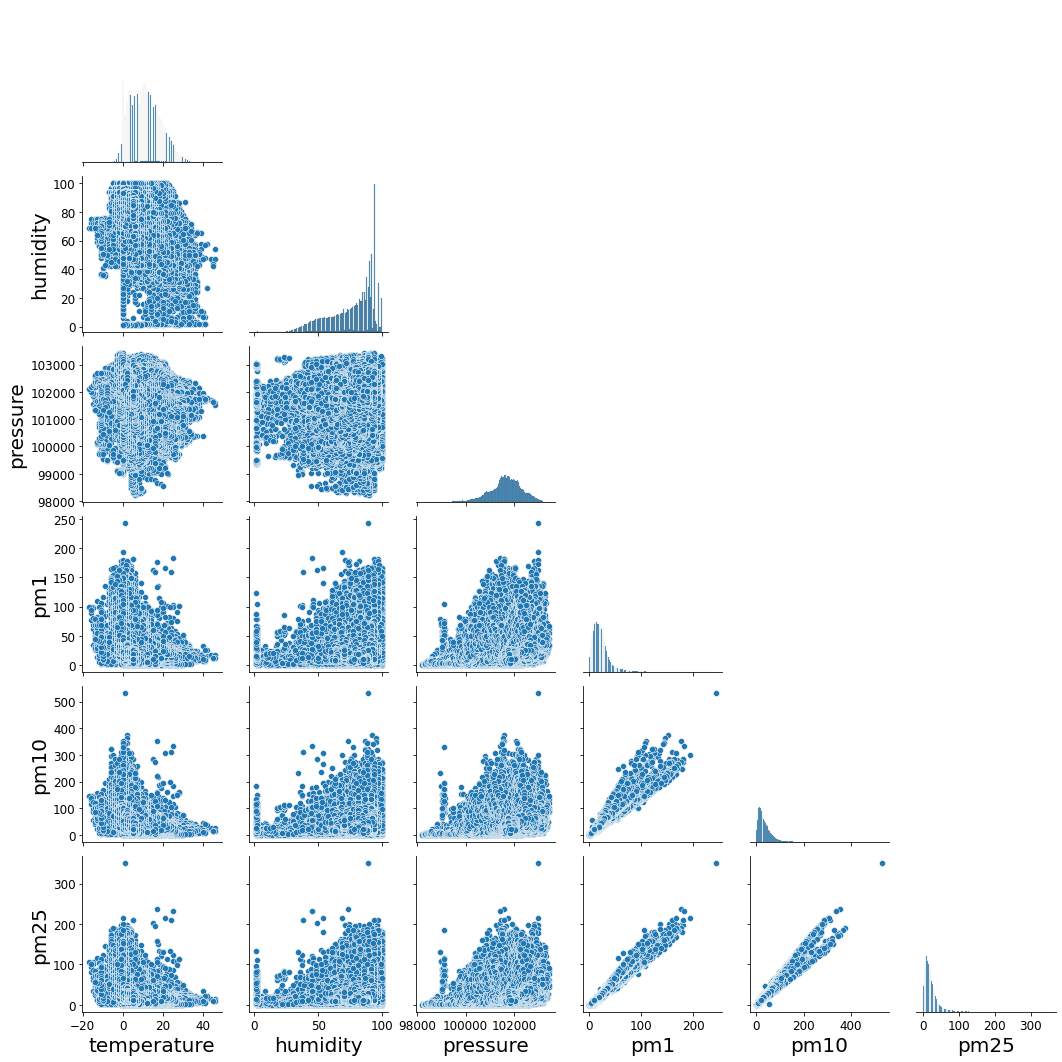

In [51]:
plt.figure(figsize=(30,30))
with sns.plotting_context(rc={"axes.labelsize":20,
                              "xtick.labelsize": 12,
                              "ytick.labelsize": 12,}):
  sns.pairplot(data=y2017[["temperature", "humidity", "pressure", "pm1", "pm10", "pm25"]], corner=True, markers=["o", "s"], palette="Set1")
plt.show()

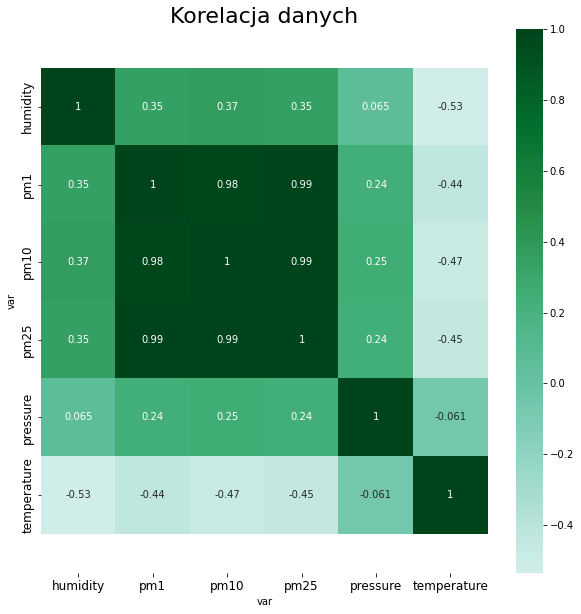

In [52]:
def print_corelogram(X,size):
  plt.figure(figsize=size)
  ax = sns.heatmap(X.corr(), 
                  xticklabels=X.corr().columns, 
                  yticklabels=X.corr().columns, 
                  cmap='BuGn', 
                  center=0, 
                  annot=True)

  plt.title("Korelacja danych", fontsize=22)
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.show()
print_corelogram(y2017,size=(10, 10))

Dzięki powyższym korelacjom mogliśmy wywnioskować, że im wyższa temperatura, tym lepsza jest jakość powietrza. Ciśnienie wykazuje pewien pozytywny stopień korelacji - im wyższe, tym też wzrasta stężenie pyłu, zwłaszcza tego o większej średnicy. Istnieje słaba ujemna korelacja między zmiennymi zanieczyszczeń, a wilgotnością. W związku z otrzymanymi wytycznymi dotyczącymi wejściowego zbioru danych, tj.:

*   PM1 nie jest skalibrowany i dlatego może być większy niż PM2,5
*   PM2,5 może być większy niż PM10 w granicach błędu pomiaru

Postanowiliśmy usunąć dane ze zbioru.

In [53]:
y2017_numeric = y2017.drop(columns={"sensor_id", "pm1", "pm25"})
sensorone = pd.get_dummies(y2017["sensor_id"], drop_first=True)
y2017_one = pd.concat([y2017_numeric, sensorone],axis=1)
y2017_one.set_index("UTC time")
y2017_one

,UTC time,humidity,pm10,pressure,temperature,142,147,169,170,171,...,226,227,228,263,3,622,713,808,857,895
1,2017-02-28 01:00:00,78.0,65.0,100378.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-02-28 01:00:00,71.0,54.0,100262.0,4.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-02-28 01:00:00,75.0,43.0,100328.0,4.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-02-28 01:00:00,73.0,52.0,100313.0,4.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,2017-02-28 01:00:00,73.0,47.0,100330.0,3.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403193,2017-12-25 00:00:00,85.0,8.0,101807.0,5.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
403195,2017-12-25 00:00:00,88.0,18.0,102040.0,5.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
403197,2017-12-25 00:00:00,86.0,21.0,101801.0,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
403198,2017-12-25 00:00:00,78.0,23.0,101774.0,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [54]:
przedzial_model = (y2017_one["UTC time"] > "2017-10-31") #Wyodrębienie potrzebnego nam przedziału czasowego
y2017_data = y2017_one.loc[przedzial_model]
len(y2017_data)

58666

In [55]:
smog_y = y2017_one[["UTC time", "pm10"]].copy()
smog_y = smog_y.set_index("UTC time")
smog_y

,pm10
UTC time,
2017-02-28 01:00:00,65.0
2017-02-28 01:00:00,54.0
2017-02-28 01:00:00,43.0
2017-02-28 01:00:00,52.0
2017-02-28 01:00:00,47.0
...,...
2017-12-25 00:00:00,8.0
2017-12-25 00:00:00,18.0
2017-12-25 00:00:00,21.0


In [56]:
smog_x = y2017_one.set_index("UTC time")
smog_x = smog_x.drop("pm10", axis=1)
smog_x

,humidity,pressure,temperature,142,147,169,170,171,172,173,...,226,227,228,263,3,622,713,808,857,895
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,78.0,100378.0,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,71.0,100262.0,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,75.0,100328.0,4.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,73.0,100313.0,4.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,73.0,100330.0,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25 00:00:00,85.0,101807.0,5.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2017-12-25 00:00:00,88.0,102040.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-12-25 00:00:00,86.0,101801.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [57]:
X = smog_x
y = smog_y

In [58]:
323030 - 58666

264364

In [59]:
X_train = X.head(264364)
X_test = X.tail(58666)

In [60]:
y_train = y.head(264364)
y_test = y.tail(58666)

In [61]:
display(y_train) 

,pm10
UTC time,
2017-02-28 01:00:00,65.0
2017-02-28 01:00:00,54.0
2017-02-28 01:00:00,43.0
2017-02-28 01:00:00,52.0
2017-02-28 01:00:00,47.0
...,...
2017-10-31 00:00:00,25.0
2017-10-31 00:00:00,59.0
2017-10-31 00:00:00,65.0


In [62]:
display(X_train)

,humidity,pressure,temperature,142,147,169,170,171,172,173,...,226,227,228,263,3,622,713,808,857,895
UTC time,,,,,,,,,,,,,,,,,,,,,
2017-02-28 01:00:00,78.0,100378.0,3.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,71.0,100262.0,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,75.0,100328.0,4.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,73.0,100313.0,4.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-02-28 01:00:00,73.0,100330.0,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 00:00:00,93.0,101945.0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2017-10-31 00:00:00,94.0,102167.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2017-10-31 00:00:00,85.0,102101.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [63]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)
y_train_dummy = dummy_model.predict(X_train)
y_test_dummy = dummy_model.predict(X_test)

In [64]:
metrics_dataframe = pd.DataFrame(columns = ["Model", "MAPE_train [%]", "MAPE_test [%]", "RMSE_train", "RMSE_test", "MAE_train", "MAE_test", "R2"])

def calculate_metrics(name, y_train, y_test, y_train_pred, y_test_pred):
  global metrics_dataframe
  MAPE_train = mean_absolute_percentage_error(y_train,y_train_pred)*100
  MAPE_test = mean_absolute_percentage_error(y_test,y_test_pred)*100

  mse_train = mean_squared_error(y_train, y_train_pred)
  mse_test = mean_squared_error(y_test, y_test_pred)
  rmse_train = sqrt(mse_train)
  rmse_test = sqrt(mse_test)

  MAE_train = mean_absolute_error(y_train, y_train_pred)
  MAE_test = mean_absolute_error(y_test, y_test_pred)

  r2 = r2_score(y_train, y_train_pred)

  metrics_dataframe = metrics_dataframe.append({"Model": name,"R2": r2,"MAE_train": MAE_train,"MAE_test": MAE_test,"MAPE_train [%]": MAPE_train,"MAPE_test [%]": MAPE_test,"RMSE_train": rmse_train,'RMSE_test': rmse_test},
                                                 ignore_index=True)
  return metrics_dataframe

In [65]:
def plot_ewaluacja(y_predict,y_test):
  plt.figure(figsize=(20,20))
  plt.scatter(x = y_predict, y = y_test, alpha=0.25, color='blue')

  xmin, xmax = y_test.min(), y_test.max()
  x_line = np.linspace(xmin, xmax, 10)
  y_line = x_line
  plt.plot(x_line, y_line, 'r--')

  plt.xlabel('Predykcja', fontsize=16)
  plt.ylabel('Wartość prawdziwa', fontsize=16)
  plt.title('Porównanie wartości prawdziwej z predykcją', fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.show()

  
  plt.figure(figsize=(20,20))
  errors = y_predict - y_test
  plt.scatter(x = y_test, y=errors, alpha = 0.25)
  plt.axhline(0,color = 'red', linestyle='--')
  plt.xlabel('Wartość prawdziwa', fontsize=16)
  plt.ylabel('Rezydua', fontsize=16)
  plt.title('Wykres reszt', fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.show()

  #Histogram reszt

  plt.figure(figsize=(20,20))
  print(f'Średni błąd: {errors.mean()}')
  plt.hist(errors, bins=20)
  plt.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=1)
  plt.title('Histogram reszt', fontsize=16)

  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)

  plt.show()

In [66]:
def rate_the_model(y_train, y_train_dummy, y_train_predict, y_test, y_test_dummy, y_test_predict):
  
  #współczynnyk determinacji:
  print(f'Współczynnyk determinacji R^2 dla modelu Dummy: {r2_score(y_train,y_train_dummy)}')
  print(f'Współczynnyk determinacji R^2 dla modelu : {r2_score(y_train, y_train_predict)}')
  print()
  #MAE
  print(f'Na danych treningowych')
  print(f'MAE dla DummyModel: {mean_absolute_error(y_train,y_train_dummy)}')
  print(f'MAE dla modelu: {mean_absolute_error(y_train,y_train_predict)}')
  print()
  print(f'\nNa danych testowych:')
  print(f'MAE dla DummyModel: {mean_absolute_error(y_test,y_test_dummy)}')
  print(f'MAE dla modelu: {mean_absolute_error(y_test,y_test_predict)}')
  print()
  #MAPE
  print(f'\nNa danych treningowych:')
  print(f'MAPE dla DummyModel: {mean_absolute_percentage_error(y_train,y_train_dummy)*100}%')
  print(f'MAPE dla modelu: {mean_absolute_percentage_error(y_train,y_train_predict)*100}%')
  print()
  print(f'\nNa danych testowych:')
  print(f'MAPE dla DummyModel: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
  print(f'MAPE dla modelu: {mean_absolute_percentage_error(y_test,y_test_predict)*100}%')
  print()
  #MSE
  print(f'\nNa danych treningowych:')
  mse_dummy_train = mean_squared_error(y_train, y_train_dummy)
  mse_model_train = mean_squared_error(y_train, y_train_predict)
  print(f'\nTest:')
  print(f'MSE dla DummyModel: {mse_dummy_train}')
  print(f'MSE dla modelu: {mse_model_train}')
  print()
  print(f'\nNa danych testowych:')
  mse_dummy_test = mean_squared_error(y_test, y_test_dummy)
  mse_model_test = mean_squared_error(y_test, y_test_predict)
  print(f'\nTest:')
  print(f'MSE dla DummyModel: {mse_dummy_test}')
  print(f'MSE dla modelu: {mse_model_test}')
  print()
  #RMSE
  print(f'\nNa danych treningowych:')
  print(f'RMSE dla DummyModel: {sqrt(mse_dummy_train)}')
  print(f'RMSE dla modelu: {sqrt(mse_model_train)}')
  print()
  print(f'\nNa danych testowych:')
  print(f'RMSE dla DummyModel: {sqrt(mse_dummy_test)}')
  print(f'RMSE dla modelu: {sqrt(mse_model_test)}')

In [67]:
calculate_metrics("Dummy Model", y_train, y_test, y_train_dummy, y_test_dummy)

,Model,MAPE_train [%],MAPE_test [%],RMSE_train,RMSE_test,MAE_train,MAE_test,R2
0,Dummy Model,3.338978e+16,69.183301,25.457535,51.335839,17.255572,37.073313,-0.067423


# **Decision Tree Model**
Z uwagii na to, że model ten jest nieparametrycznym, to nie wymaga on standaryzacji danych. Do wyboru najlepszych parametrów użyliśmy GridSearchu w cross-walidacji stosująć TimeSeriesSplit, który zbiory walidacyjne dzieli ze względu na wystepowanie w czasie.

In [68]:
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
#Stworzenie modelu drzewa decyzyjnego
tree_model_one = DecisionTreeRegressor()

#Model sprawdzi poniższe hiperparametry
params = {'max_depth': [2, 2, 3, 4, 5, 5, 6, 7, 9, 10, 11], 
          'min_samples_leaf':[2, 2, 3, 3, 4, 4, 5, 6, 10, 12, 13]}

#Stworzenie GridSearch'a, który wyszuka najlepsze parametry, jednocześnie tworząc zbiór walidacyjny za pomocą cross-walidacji
tree_regression_gridsearch_one = GridSearchCV(tree_model_one, 
                                                params, #parametry do sprawdzenia
                                                scoring='neg_mean_squared_error',
                                                cv=tscv, #cross walidacja
                                                verbose=10) #verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model

#trenowanie modelu na tym z najlepszymi parametrami
tree_regression_gridsearch_one.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_regression_gridsearch_one.best_params_)

tree_regression_model_one = tree_regression_gridsearch_one.best_estimator_

Fitting 3 folds for each of 121 candidates, totalling 363 fits
[CV 1/3; 1/121] START max_depth=2, min_samples_leaf=2...........................
[CV 1/3; 1/121] END max_depth=2, min_samples_leaf=2;, score=-487.484 total time=   0.2s
[CV 2/3; 1/121] START max_depth=2, min_samples_leaf=2...........................
[CV 2/3; 1/121] END max_depth=2, min_samples_leaf=2;, score=-212.560 total time=   0.3s
[CV 3/3; 1/121] START max_depth=2, min_samples_leaf=2...........................
[CV 3/3; 1/121] END max_depth=2, min_samples_leaf=2;, score=-541.985 total time=   0.4s
[CV 1/3; 2/121] START max_depth=2, min_samples_leaf=2...........................
[CV 1/3; 2/121] END max_depth=2, min_samples_leaf=2;, score=-487.484 total time=   0.2s
[CV 2/3; 2/121] START max_depth=2, min_samples_leaf=2...........................
[CV 2/3; 2/121] END max_depth=2, min_samples_leaf=2;, score=-212.560 total time=   0.3s
[CV 3/3; 2/121] START max_depth=2, min_samples_leaf=2...........................
[CV 3/3; 2/

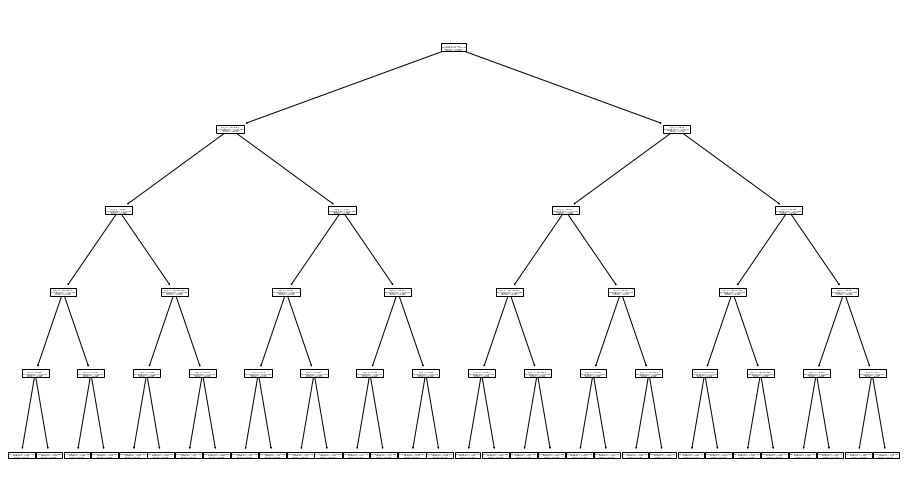

In [69]:
plt.figure(figsize=(16,9))
tree.plot_tree(tree_regression_model_one)
plt.show()

In [70]:
y_predict_train_model_tree1 = tree_regression_model_one.predict(X_train)
y_predict_test_model_tree1 = tree_regression_model_one.predict(X_test)

In [71]:
calculate_metrics("Drzewo decyzyjne", y_train, y_test, y_predict_train_model_tree1, y_predict_test_model_tree1)

,Model,MAPE_train [%],MAPE_test [%],RMSE_train,RMSE_test,MAE_train,MAE_test,R2
0,Dummy Model,3.338978e+16,69.183301,25.457535,51.335839,17.255572,37.073313,-0.067423
1,Drzewo decyzyjne,3.036107e+16,78.748902,19.699574,39.853322,14.235884,28.584868,0.360829


In [72]:
#print('Drzewo decyzyjne')
#plot_ewaluacja(y_predict_test_model_tree1, y_test)

In [73]:
rate_the_model(y_train, y_train_dummy, y_predict_train_model_tree1, y_test, y_test_dummy, y_predict_test_model_tree1)

Współczynnyk determinacji R^2 dla modelu Dummy: -0.06742252798874326
Współczynnyk determinacji R^2 dla modelu : 0.36082862463375387

Na danych treningowych
MAE dla DummyModel: 17.25557186303733
MAE dla modelu: 14.235884130586602


Na danych testowych:
MAE dla DummyModel: 37.07331333310606
MAE dla modelu: 28.58486790239729


Na danych treningowych:
MAPE dla DummyModel: 3.338977799415275e+16%
MAPE dla modelu: 3.036106810880025e+16%


Na danych testowych:
MAPE dla DummyModel: 69.18330148411475%
MAPE dla modelu: 78.74890246710005%


Na danych treningowych:

Test:
MSE dla DummyModel: 648.0861009819794
MSE dla modelu: 388.07320780545496


Na danych testowych:

Test:
MSE dla DummyModel: 2635.3684075955407
MSE dla modelu: 1588.2872911370143


Na danych treningowych:
RMSE dla DummyModel: 25.45753524954801
RMSE dla modelu: 19.69957379755854


Na danych testowych:
RMSE dla DummyModel: 51.335839406749166
RMSE dla modelu: 39.85332220953498


# **Random Forest**

In [75]:
random_forest = RandomForestRegressor(n_jobs=-1,max_features=0.33)
tscv = TimeSeriesSplit(n_splits=5).split(X_train)

params_rf = {'max_depth': [2, 3, 5, 10, 20, 25],
             'min_samples_leaf': [7, 10, 25, 50],
             'n_estimators': [5, 10, 20]} 

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf, 
                             scoring='neg_mean_absolute_error',
                             cv=tscv,
                             verbose=10, 
                             n_jobs=-1)
rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)

random_forest = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 25, 'n_estimators': 10}


In [76]:
y_predict_train_random_forest = random_forest.predict(X_train)
y_predict_test_random_forest = random_forest.predict(X_test)

In [77]:
rate_the_model(y_train, y_train_dummy, y_predict_train_random_forest, y_test, y_test_dummy, y_predict_test_random_forest)

Współczynnyk determinacji R^2 dla modelu Dummy: -0.06742252798874326
Współczynnyk determinacji R^2 dla modelu : 0.3322833679042929

Na danych treningowych
MAE dla DummyModel: 17.25557186303733
MAE dla modelu: 14.613187286758434


Na danych testowych:
MAE dla DummyModel: 37.07331333310606
MAE dla modelu: 26.049015341897682


Na danych treningowych:
MAPE dla DummyModel: 3.338977799415275e+16%
MAPE dla modelu: 3.4514473665902264e+16%


Na danych testowych:
MAPE dla DummyModel: 69.18330148411475%
MAPE dla modelu: 75.86886161561%


Na danych treningowych:

Test:
MSE dla DummyModel: 648.0861009819794
MSE dla modelu: 405.4044741505485


Na danych testowych:

Test:
MSE dla DummyModel: 2635.3684075955407
MSE dla modelu: 1354.3061184090227


Na danych treningowych:
RMSE dla DummyModel: 25.45753524954801
RMSE dla modelu: 20.13465853076601


Na danych testowych:
RMSE dla DummyModel: 51.335839406749166
RMSE dla modelu: 36.80089833698388


# **Polynomial Regression**

In [ ]:
tscv = TimeSeriesSplit(n_splits=3).split(X_train)
polynomial_regression_pipeline = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression()) #pipeline tworzacy model rekresji wielomianu
# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3,]}

polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=tscv,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch.best_params_)

polynomial_regression_model = polynomial_regression_gridsearch.best_estimator_

In [ ]:
y_predict_train_polynomial_regression = polynomial_regression_model.predict(X_train)
y_predict_test_polynomial_regression = polynomial_regression_model.predict(X_test)

In [ ]:
rate_the_model(y_train, y_train_dummy, y_predict_train_polynomial_regression, y_test, y_test_dummy, y_predict_test_polynomial_regression)

In [ ]:
import joblib
import pickle

final_model = 
#Zapisywanie modelu na dysku
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [ ]:
import pickle
#Wczytywanie modelu z dysku
filename = 'final_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))